# Adequacy Assesment
## Modeling the Outages in Network as random variables



In [233]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon
from scipy.optimize import curve_fit
import datetime
#import pandasql as ps

def import_df(path, cols = ['StartTS', 'EndTS', 'TimeZone', 'Status', 'Type', 'AreaCode',
       'AreaTypeCode', 'AreaName', 'MapCode', 'PowerResourceEIC', 'UnitName',
       'ProductionType', 'InstalledCapacity', 'AvailableCapacity',
       'Reason']):
    """
    imports and preprocess data_frame
    path: string containing path of csv file containing table
    cols: list of column names to select in df
    returns: non redundat dataframe with only failures
    """
    
    df = pd.read_csv(path, sep = "\t", parse_dates = [0,1])
    df = df[cols] #selects only column
    df = df.drop_duplicates(subset = ["UnitName","StartTS"]) #deletes redundant rows
    df = df[(df["Reason"] == "Failure")] # WHERE | (df["Reason"] == 'Foreseen Maintenance')
    return df
    
    

In [ ]:
#todo ---) given unitname startTS endTS say whether two events coincide

# Getting to know the dataframe

In [91]:
#repository = "UnavailabilityOfGenerationUnits"
path = r'U:\ENTSO-E Transparency Platform\UnavailabilityOfGenerationUnits_15.1.A_B'

# Enclose the path in double quotes
repository = f'{path}'

#print(os.listdir(repository))

file_name = os.listdir(repository)[0]
complete_path = os.path.join(repository,file_name)
print(complete_path)
df = pd.read_csv(complete_path, sep = "\t", parse_dates = [0,1])

#Dataframe snippet
#df.head(15)

#df = df[(df["Reason"] == "Failure")]
#df = df[df["ProductionType"] == "Fossil Gas "]

U:\ENTSO-E Transparency Platform\UnavailabilityOfGenerationUnits_15.1.A_B\2014_12_UnavailabilityOfGenerationUnits_15.1.A_B.csv


In [93]:
#Rumbling

#Column names
print("--The columns names are:", list(df.columns))

#Dates somethin happened
#print(df["StartTS"].unique())

#Possible generator status
reasons = list(df["Reason"].unique())
print("--The possible reason of a generator failure are:",reasons)

#Possible Areas
#list(df["AreaCode"].unique())
area_codes = list(df["MapCode"].unique())
print("--Mapcode:",area_codes)

#Type of generator
generator_types = list(df["ProductionType"].unique())
print("--ProductionType:",generator_types)

#Type of variable
print("--dtype of variables:",df.dtypes)


--The columns names are: ['StartTS', 'EndTS', 'TimeZone', 'MRID', 'Status', 'Type', 'AreaCode', 'AreaTypeCode', 'AreaName', 'MapCode', 'PowerResourceEIC', 'UnitName', 'ProductionType', 'InstalledCapacity', 'AvailableCapacity', 'Version', 'Reason', 'UpdateTime']
--The possible reason of a generator failure are: ['Failure', 'Complementary Information', 'Foreseen Maintenance', 'Shutdown']
--Mapcode: ['PT', 'ES', 'FR', 'FI', 'SE3', 'SE', 'EE', 'SE1', 'NO2', 'NL', 'NO', 'HU', 'NO4', 'CZ', 'GB', 'PL', 'NO5', 'RO']
--ProductionType: ['Fossil Gas ', 'Fossil Hard coal ', 'Hydro Run-of-river and poundage ', 'Nuclear ', 'Hydro Pumped Storage ', 'Hydro Water Reservoir ', 'Fossil Brown coal/Lignite ', 'Fossil Oil ', 'Fossil Oil shale ', 'Biomass ', 'Fossil Peat ']
--dtype of variables: StartTS              datetime64[ns]
EndTS                datetime64[ns]
TimeZone                     object
MRID                         object
Status                       object
Type                         object


Basically to approximate the distribution we want to  1) groupby, Country and  ProductionType (and Reason Of Generato Failure) and then 2) Count occurances for every -unit time- and then 3) Sum the corresponding counts over the years (using something like "like" from SQL).ù


In [94]:
#Counts number of outages in each groups
grouped = df.groupby(["ProductionType","MapCode","Reason", pd.Grouper(key = "StartTS", freq = "W")])["Status"].count().reset_index()
result = grouped.append(grouped,ignore_index = False)
result

C:\Users\riccaga\AppData\Local\Temp\1\ipykernel_3716\48686392.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = grouped.append(grouped,ignore_index = False)


ProductionType MapCode                Reason    StartTS  Status
0         Biomass       GB               Failure 2014-12-07     152
1         Biomass       GB               Failure 2014-12-14     156
2         Biomass       GB               Failure 2014-12-21      70
3         Biomass       GB               Failure 2014-12-28      44
4         Biomass       GB  Foreseen Maintenance 2014-12-21      30
..             ...     ...                   ...        ...     ...
137       Nuclear       GB  Foreseen Maintenance 2014-12-14       3
138       Nuclear       SE               Failure 2014-12-21       3
139       Nuclear       SE               Failure 2014-12-28       9
140       Nuclear      SE3               Failure 2014-12-21       3
141       Nuclear      SE3               Failure 2014-12-28       9

[284 rows x 5 columns]

### Datetime Datatype 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html

In [95]:
print(df["StartTS"][0].week)


49


In [ ]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
#
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

from sklearn.neighbors import KernelDensity

# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.random.exponential(scale = 1, size=1000)
X = X[:, np.newaxis]
#X = np.concatenate(
#    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
#)[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc="#AAAAFF", density=True)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc="#AAAAFF", density=True)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel="tophat", bandwidth=0.15).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), "+k")
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel("Normalized Density")

for axi in ax[1, :]:
    axi.set_xlabel("x")

# ----------------------------------------------------------------------
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return "0"
    elif x == 1:
        return "h"
    elif x == -1:
        return "-h"
    else:
        return "%ih" % x


for i, kernel in enumerate(
    ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), "-k", fc="#AAAAFF")
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title("Available Kernels")

# ----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

In [ ]:
#ChatGPT optimization ----> good ideas but must be fixed
start_time = np.datetime64("2023-01-01T00:00:00")
end_time = np.datetime64("2023-06-01T00:00:00")

n_hours = 100 #(end_time - start_time) / np.timedelta64(1, "h")
grouped  = df.groupby(["UnitName"]).head()
gen_names = list(grouped["UnitName"])
gen_types = list(grouped["ProductionType"])
n_gens = len(gen_names)
states = ["Running", "Forced", "Planned"]
data_list = []
current_time = start_time
state_df = pd.DataFrame({"UnitName": gen_names, "ProductionType": gen_types, "State":["Running"]*n_gens, "Counter":[0]*n_gens, "Capacity":[1]*n_gens})

data_list = []
state_df["TimeStamp"] = pd.date_range(start=start_time, periods=n_hours, freq='H')

for h in range(tot_hours):
    if h % perc == 0:
        print(f"{h/tot_hours *100} %")
        print(state_df.head(1))

    # Calculate new states and counters
    state_df["NewState"] = state_df.apply(lambda row: next_state_markov(markov_d[row["ProductionType"]], row["State"]), axis=1)
    state_df["NewCounter"] = np.random.exponential(state_df.apply(lambda row: params.loc[params["ProductionType"] == row["ProductionType"], row["State"] + "Time"], axis=1))

    # Update counters
    state_df.loc[state_df["Counter"] != 0, "Counter"] -= 1

    # Update states and capacities
    state_df["State"] = np.where(state_df["Counter"] == 0, state_df["NewState"], state_df["State"])
    state_df["Counter"] = np.where(state_df["Counter"] == 0, state_df["NewCounter"], state_df["Counter"])
    state_df["Capacity"] = np.where(
        (state_df["NewState"] == "Running") | (~state_df.apply(lambda row: np.random.random_sample() <= pdf_pu.get((row["ProductionType"], row["NewState"]), (0, None))[0], axis=1)),
        1,
        np.clip(pdf_pu.get((row["ProductionType"], row["NewState"]), (0, None))[1].sample(), 0, 1)
    )

    # Add the row to data_list
    data_list.append(state_df[["TimeStamp"] + gen_names].iloc[0].to_dict())

# Create the scenario DataFrame
scenario = pd.DataFrame(data_list)

# Occurances every week during the year
### (by production type, not by country)
for each file
    group by an count
    add date column if file are divided by dates
    

In [96]:
count_df = pd.DataFrame()
for file_name in os.listdir(repository):
    print(file_name)
    complete_path = os.path.join(repository,file_name)
    #print(complete_path)
    df = pd.read_csv(complete_path, sep = "\t", parse_dates = [0,1])[["ProductionType","MapCode","Reason","StartTS","Status"]]
    grouped = df.groupby(["ProductionType","MapCode","Reason",pd.Grouper(key = "StartTS", freq = "M")]).count()
    #grouped = grouped.rename(columns = {"Status":"Count"})
    count_df = pd.concat([count_df,grouped])




2014_12_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_01_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_02_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_03_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_04_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_05_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_06_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_07_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_08_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_09_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_10_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_11_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2015_12_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2016_01_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2016_02_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2016_03_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2016_04_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2016_05_UnavailabilityOfGenerationUnits_15.1.A_B.csv
2016_06_UnavailabilityOfGenerationUnits_15.1.A

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [231]:
#count_df.to_csv('count_df.csv', index=False)
count_df = pd.read_csv("count_df.csv", parse_dates = [0,1])
count_df["StartTS"] = pd.to_datetime(count_df["StartTS"])
#count_df
delta_df = pd.read_csv("deltaWithEverything_df.csv", parse_dates = [0,1])


StartTS               EndTS TimeZone     Status     Type  \
0      2021-07-14 09:00:00 2021-07-14 10:00:00      CET     Active   Forced   
1      2021-07-14 11:00:00 2021-07-14 23:59:00      CET     Active   Forced   
2      2021-07-15 15:00:00 2022-01-01 00:00:00      CET     Active   Forced   
3      2021-10-01 00:00:00 2021-10-01 01:00:00      CET     Active   Forced   
4      2021-10-01 01:00:00 2021-10-01 02:00:00      CET     Active   Forced   
...                    ...                 ...      ...        ...      ...   
573770 2021-09-16 00:00:00 2021-09-18 00:00:00      CET  Cancelled  Planned   
573771 2021-09-17 00:00:00 2021-09-18 00:00:00      CET  Cancelled  Planned   
573772 2022-06-19 00:00:00 2022-07-18 00:00:00      CET     Active  Planned   
573773 2022-07-10 00:00:00 2022-08-09 00:00:00      CET  Cancelled  Planned   
573774 2024-06-08 00:00:00 2024-07-01 00:00:00      CET     Active  Planned   

                AreaCode AreaTypeCode AreaName MapCode  PowerResourceEIC  \
0       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
1       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
2       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
3       10YES-REE------0          BZN   ES BZN      ES  18WABO1-12345-D7   
4       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
...                  ...          ...      ...     ...               ...   
573770  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573771  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573772  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573773  10YHU-MAVIR----U          BZN   HU BZN      HU  15WUJPESTG2--STI   
573774  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   

       UnitName     ProductionType  InstalledCapacity  AvailableCapacity  \
0       ABO¿O 1  Fossil Hard coal               341.7              230.0   
1       ABO¿O 1  Fossil Hard coal               341.7              220.0   
2       ABO¿O 1  Fossil Hard coal               341.7                0.0   
3       ABO¿O 1  Fossil Hard coal               341.7              190.0   
4       ABO¿O 1  Fossil Hard coal               341.7              210.0   
...         ...                ...                ...                ...   
573770    ÚJ_ST        Fossil Gas                33.0                0.0   
573771    ÚJ_ST        Fossil Gas                33.0                0.0   
573772    ÚJ_ST        Fossil Gas                33.0                0.0   
573773    ÚJ_ST        Fossil Gas                33.0                0.0   
573774    ÚJ_ST        Fossil Gas                33.0                0.0   

        Version                     Reason             UpTime  
0             1                    Failure                NaN  
1             7                    Failure    0 days 02:00:00  
2             5                    Failure    1 days 04:00:00  
3             1  Complementary Information   77 days 09:00:00  
4             1  Complementary Information    0 days 01:00:00  
...         ...                        ...                ...  
573770        2       Foreseen Maintenance    1 days 00:00:00  
573771        2       Foreseen Maintenance    1 days 00:00:00  
573772        1       Foreseen Maintenance  275 days 00:00:00  
573773        2  Complementary Information   21 days 00:00:00  
573774        1       Foreseen Maintenance  699 days 00:00:00  

[573775 rows x 17 columns]

In [235]:
count_df = count_df[count_df["StartTS"] < datetime.datetime(2022, 1, 1, 1, 00,00)]

ProductionType MapCode                     Reason    StartTS  Status
0            Biomass       GB                    Failure 2014-12-07     152
1            Biomass       GB                    Failure 2014-12-14     156
2            Biomass       GB                    Failure 2014-12-21      70
3            Biomass       GB                    Failure 2014-12-28      44
4            Biomass       GB       Foreseen Maintenance 2014-12-21      30
...               ...     ...                        ...        ...     ...
77639          Solar       HU                   Shutdown 2021-12-12      14
77640          Solar       HU                   Shutdown 2021-12-19      14
77641          Solar       HU                   Shutdown 2021-12-26      14
77643  Wind Offshore       BE  Complementary Information 2021-12-26       8
77644   Wind Onshore       GB       Foreseen Maintenance 2021-12-05       2

[77496 rows x 5 columns]

We now group by week of the year and sum to get the sum spanning over every year.

In [109]:
def get_week(date):
    return date.week
#print(list(count_df.columns))
count_df["StartTS"] = pd.to_datetime(count_df['StartTS'])
count_df["Week"] = count_df["StartTS"].apply(get_week)
distributions = count_df.groupby(["ProductionType","Reason","Week"])["Status"].sum()
distributions = distributions.reset_index()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


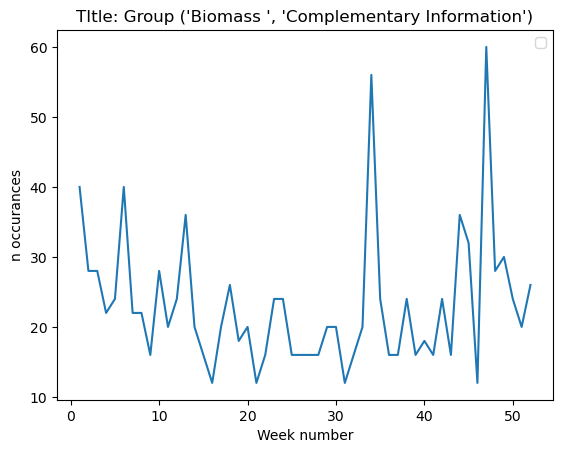

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


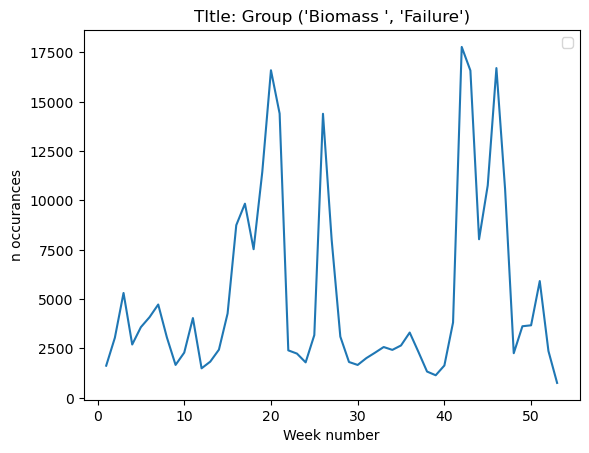

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


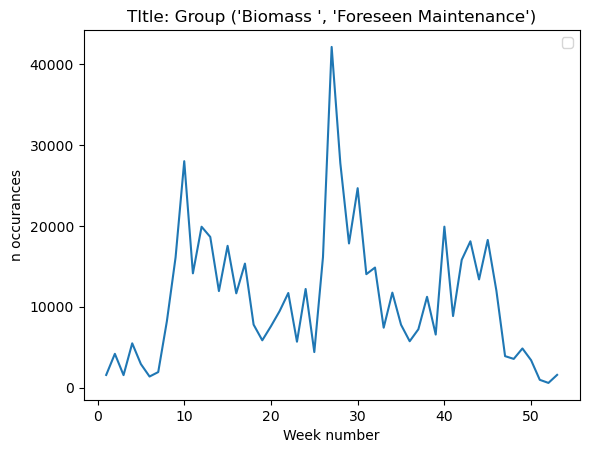

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


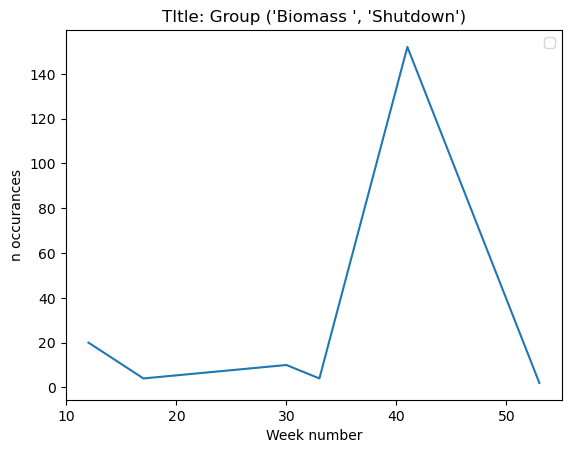

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


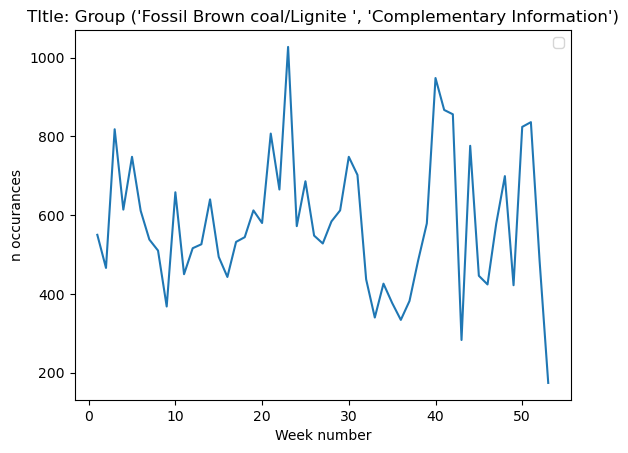

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


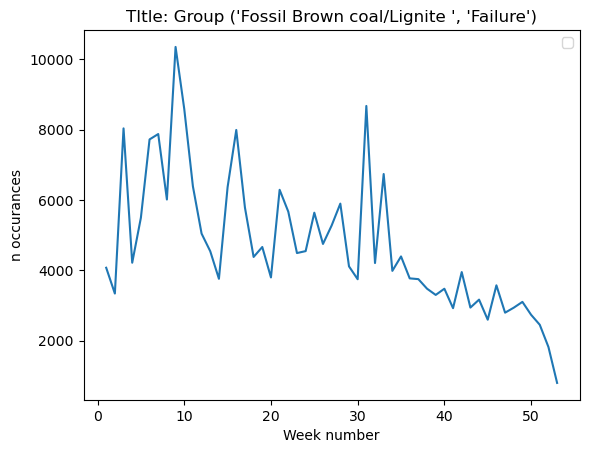

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


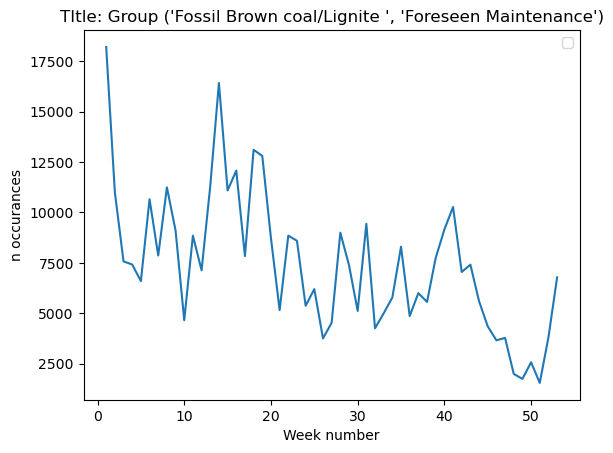

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


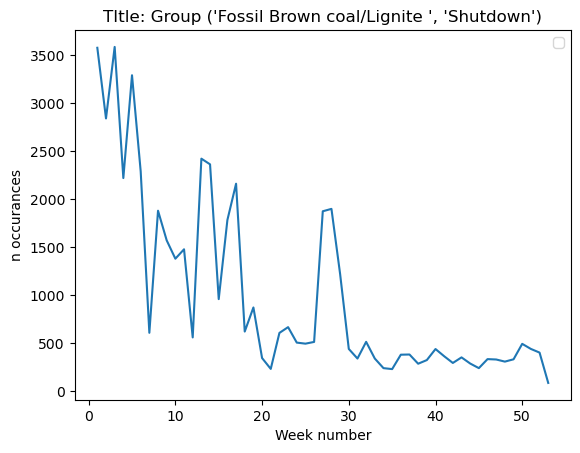

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


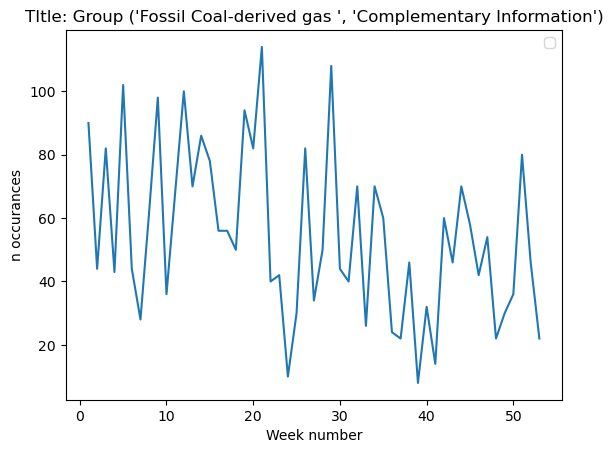

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


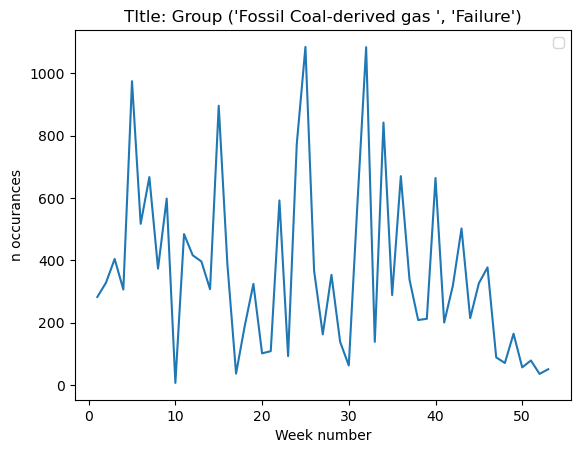

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


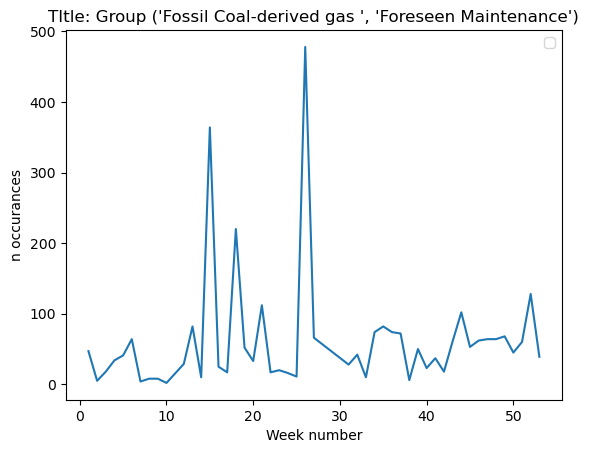

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


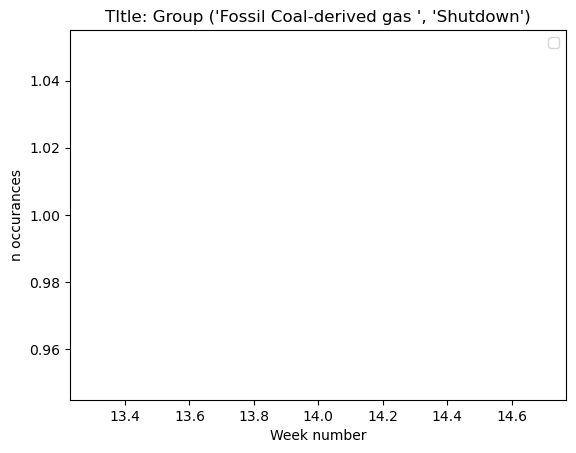

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


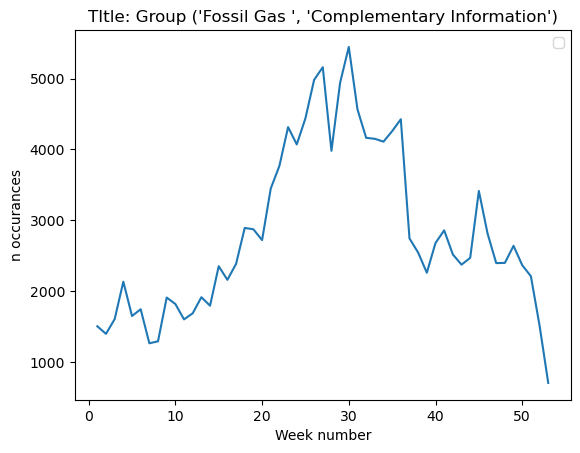

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


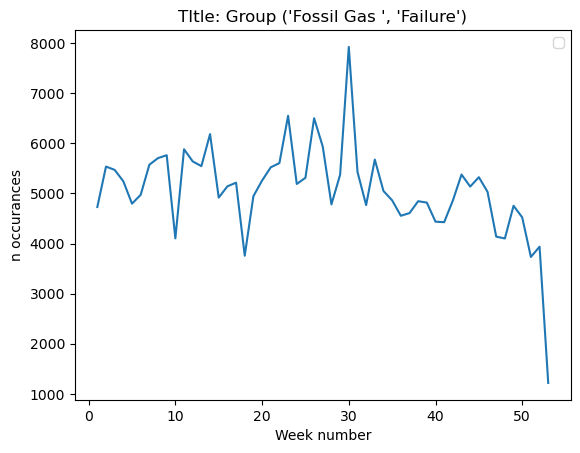

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


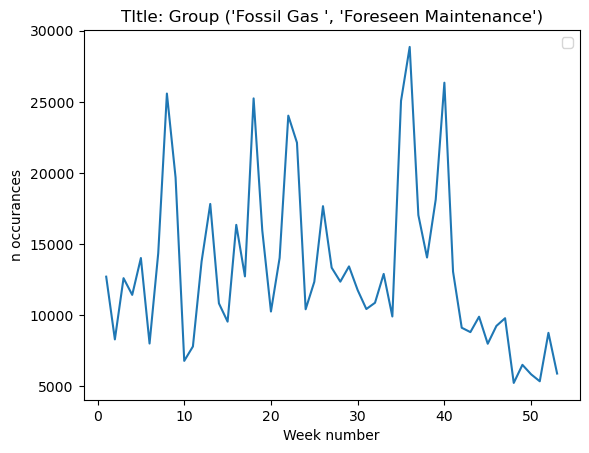

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


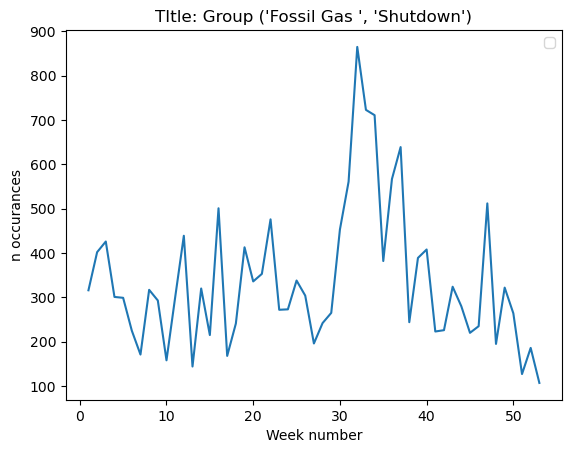

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


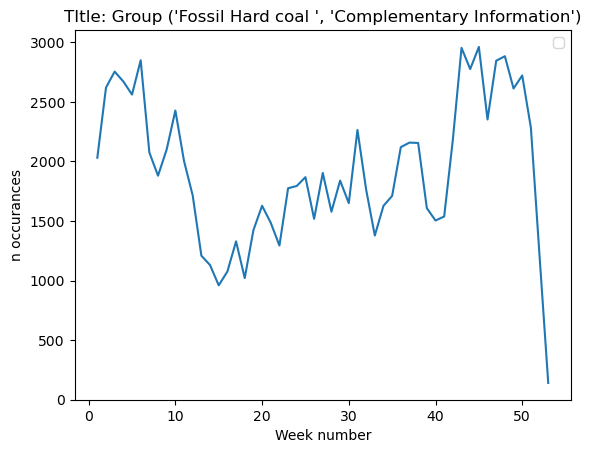

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


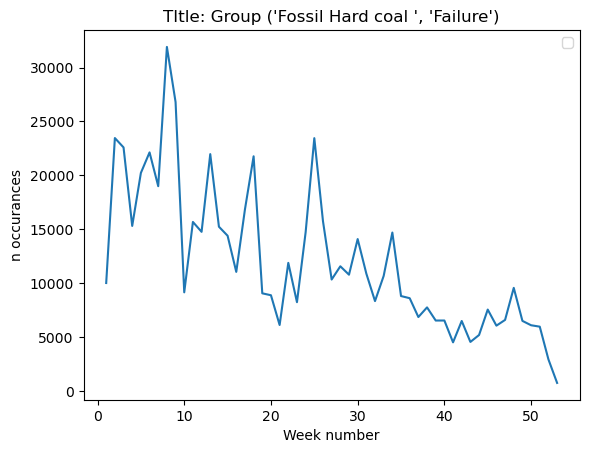

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


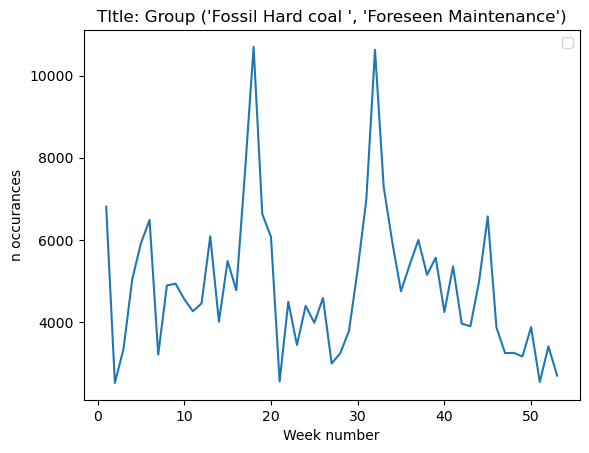

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


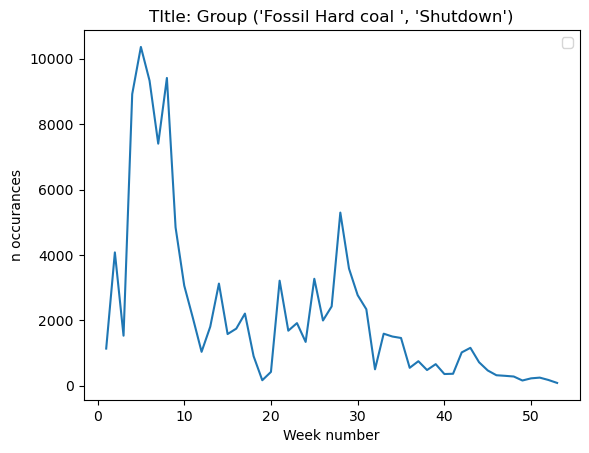

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


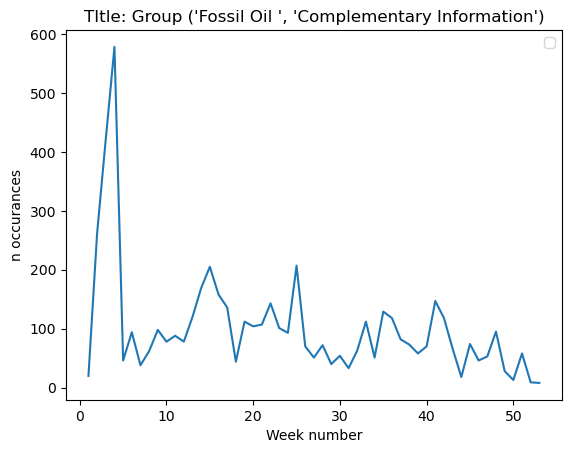

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


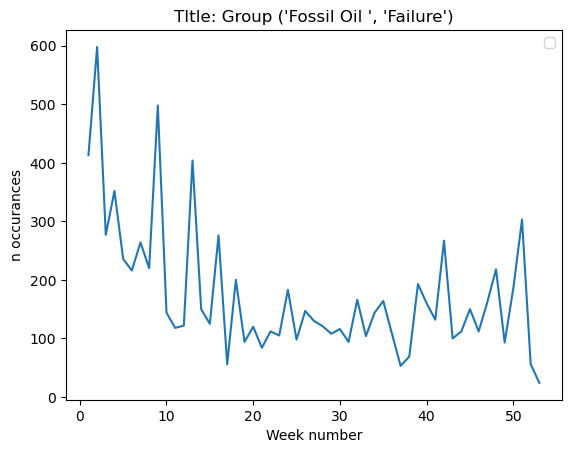

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


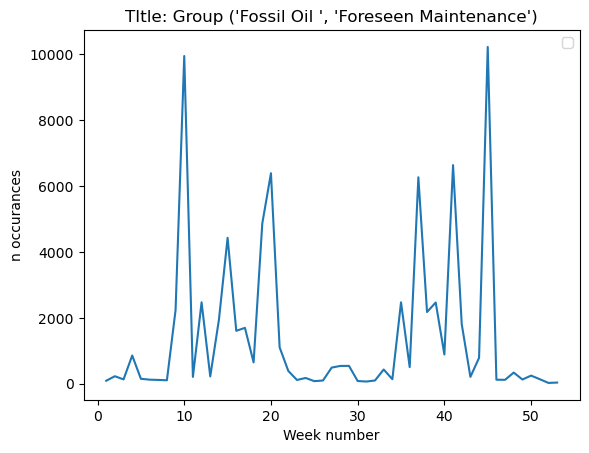

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


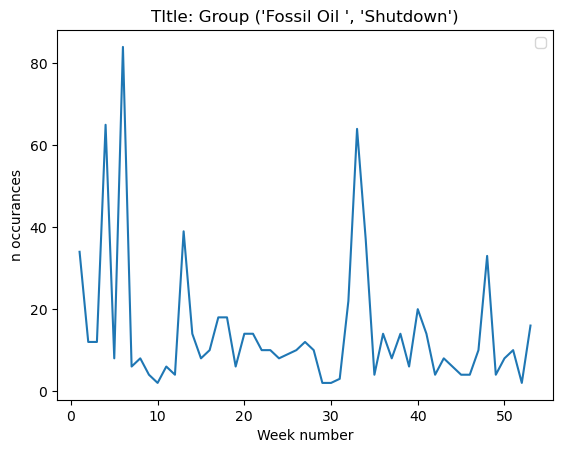

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


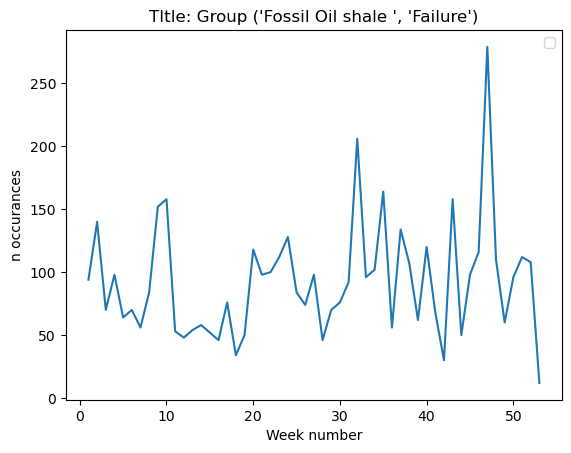

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


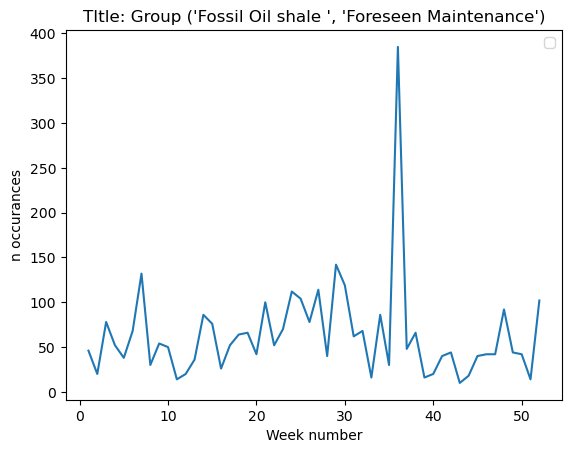

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


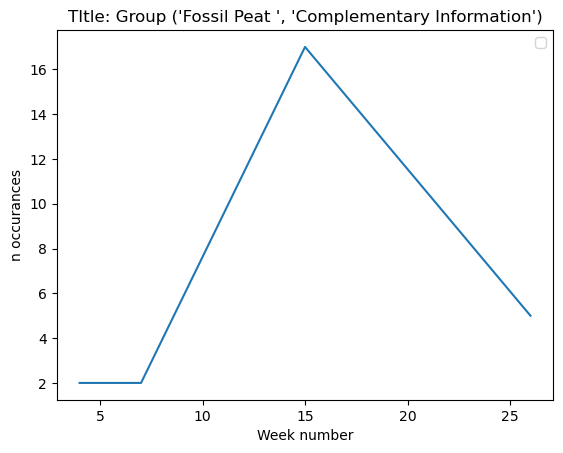

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


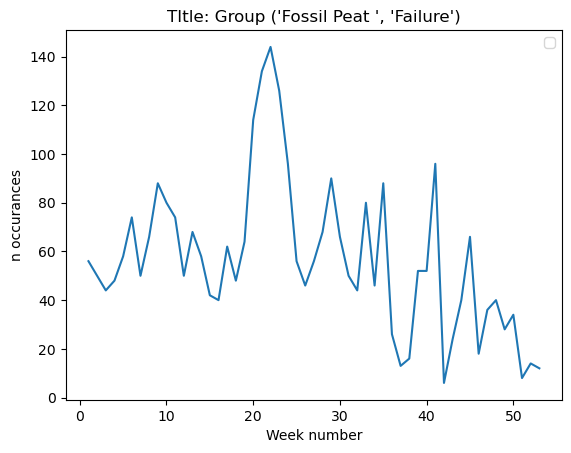

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


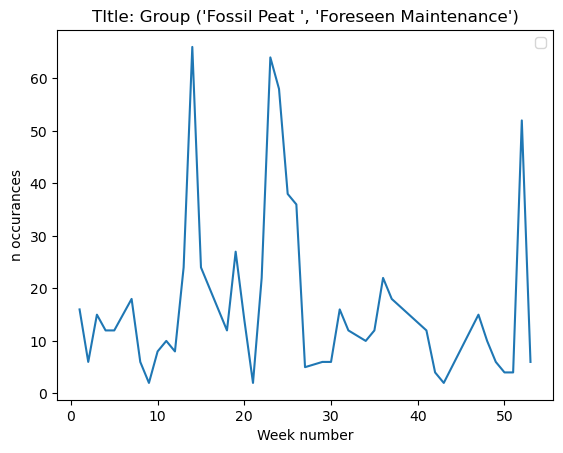

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


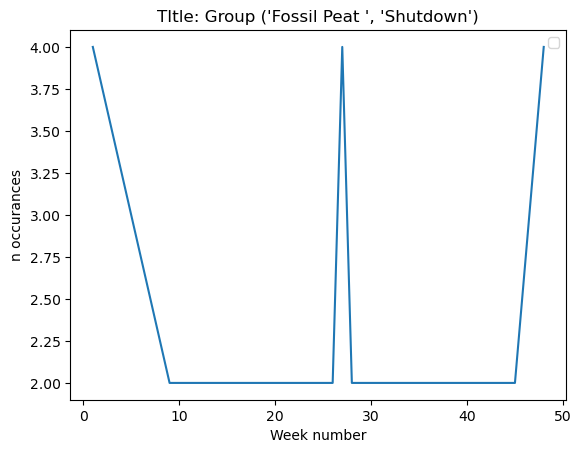

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


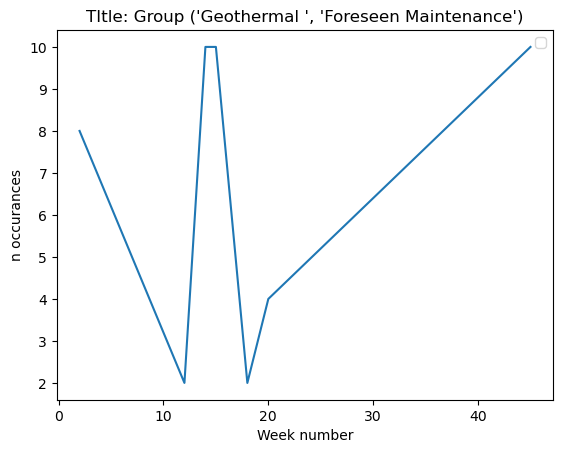

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


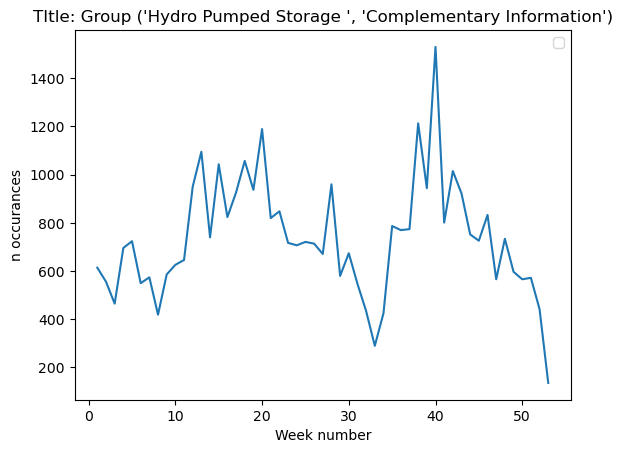

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


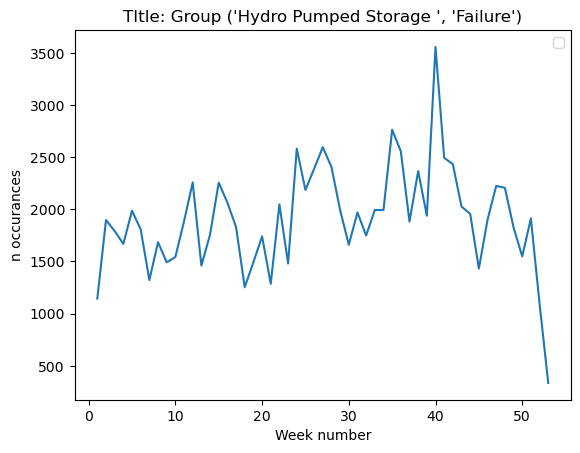

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


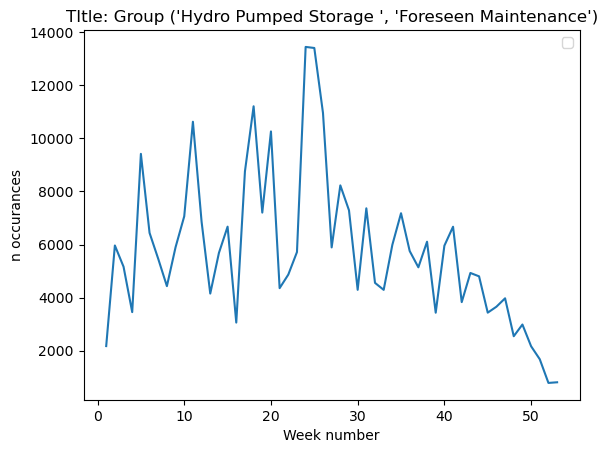

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


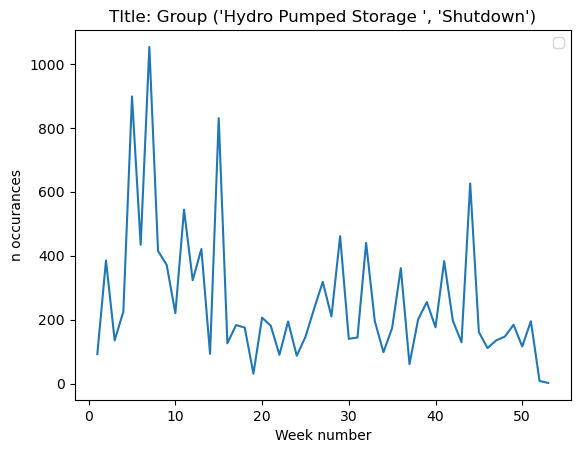

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


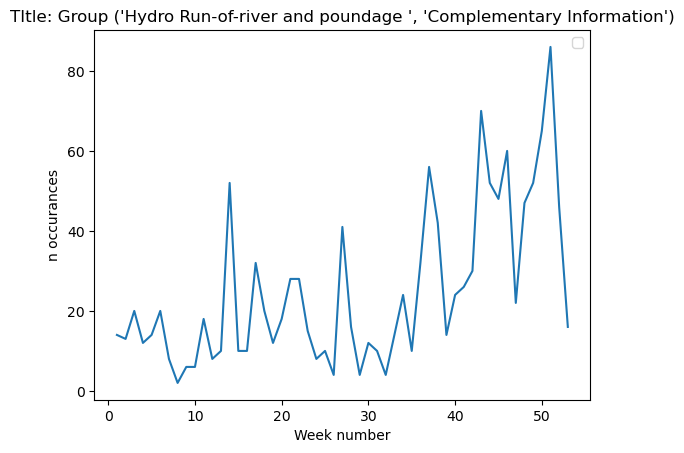

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


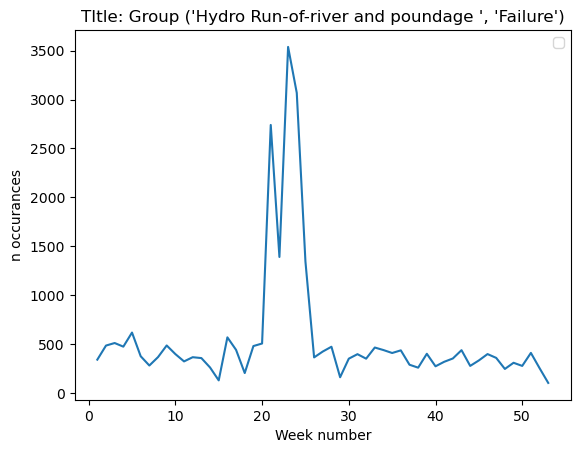

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


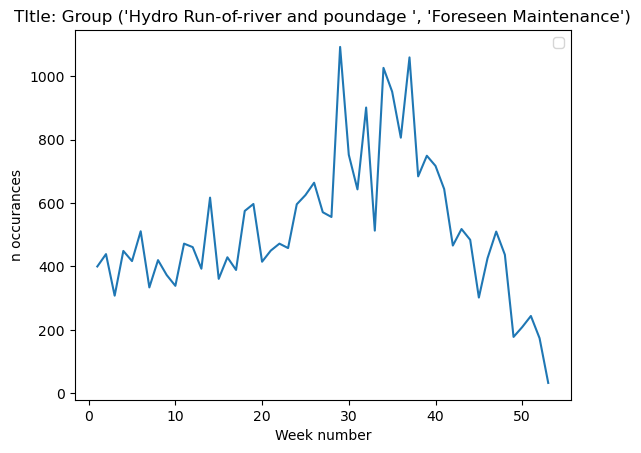

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


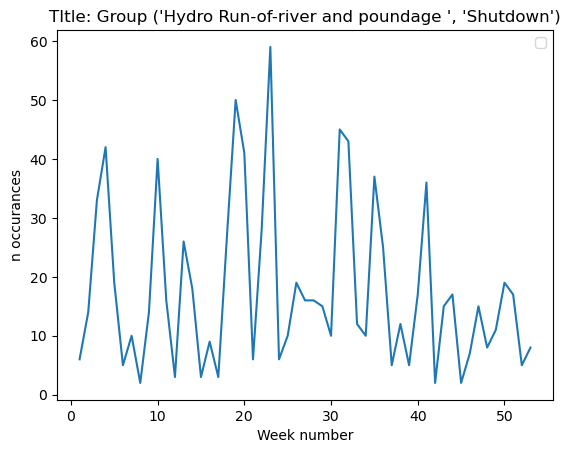

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


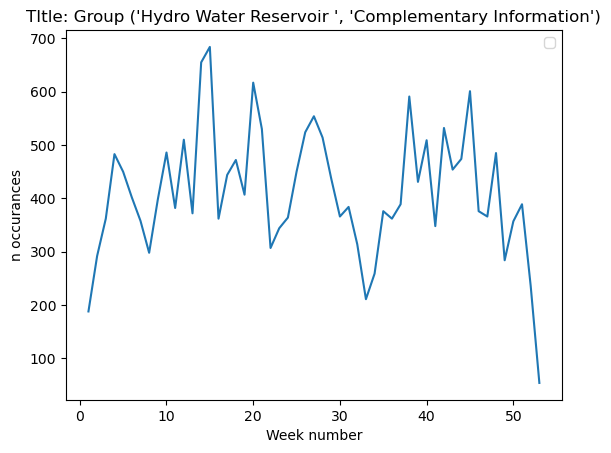

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


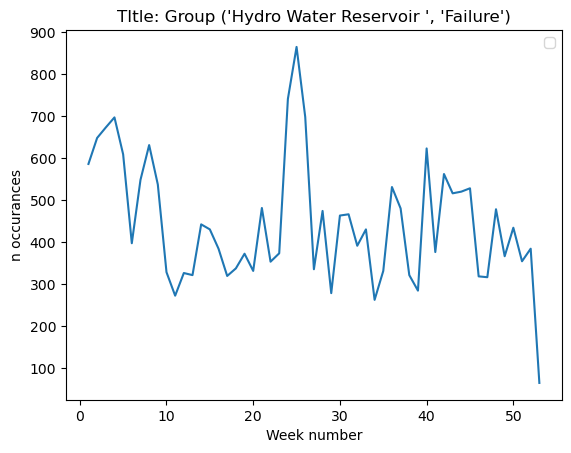

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


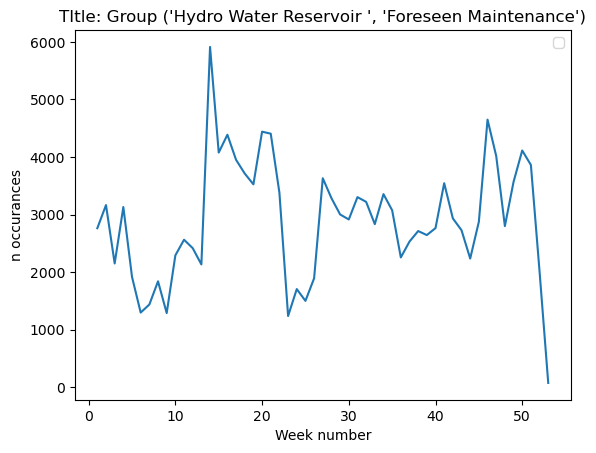

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


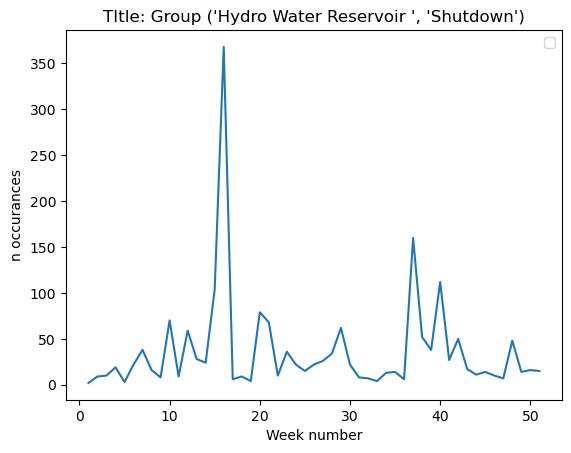

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


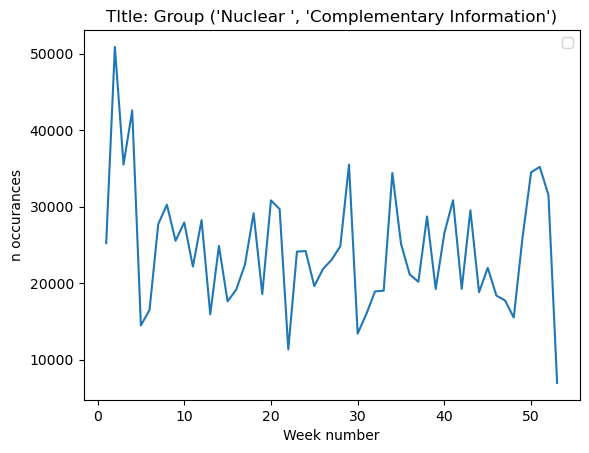

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


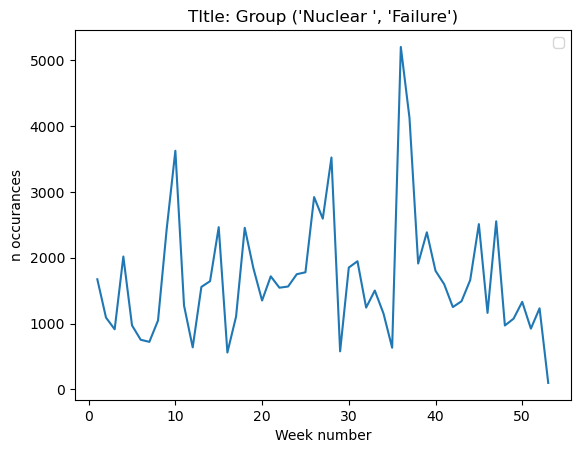

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


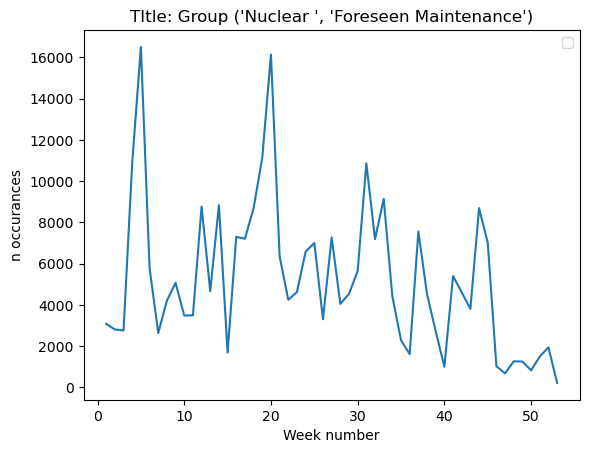

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


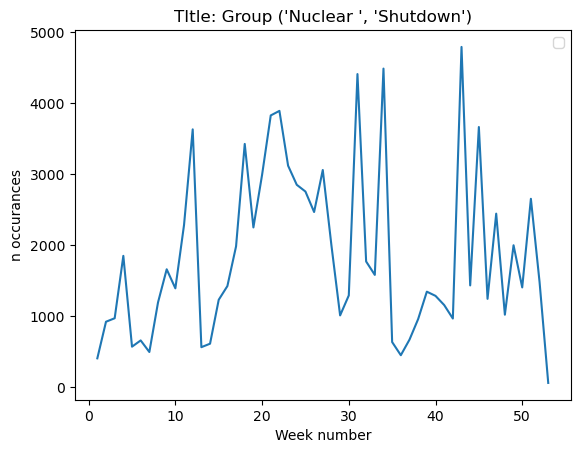

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


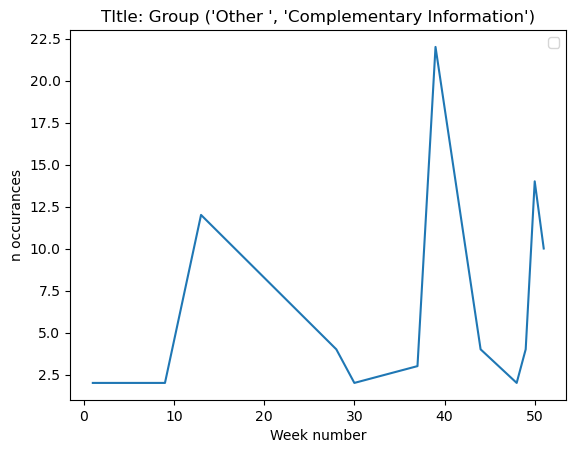

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


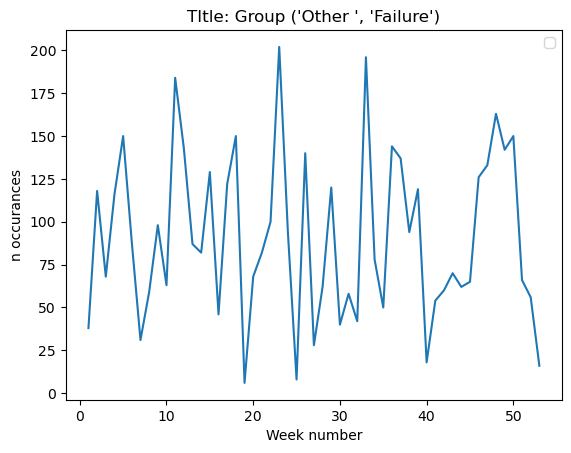

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


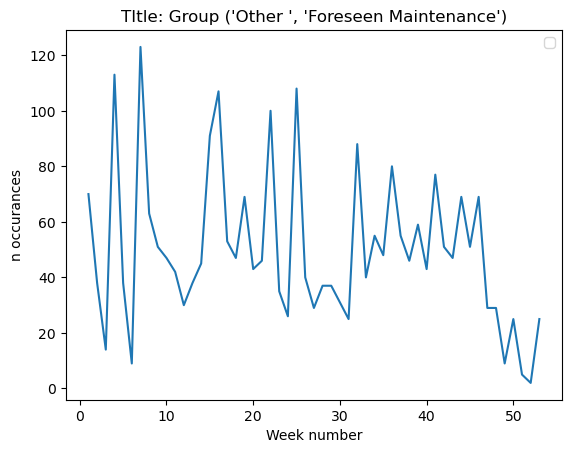

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


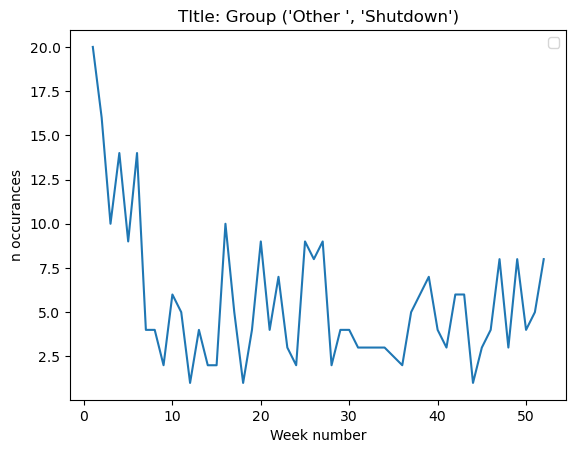

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


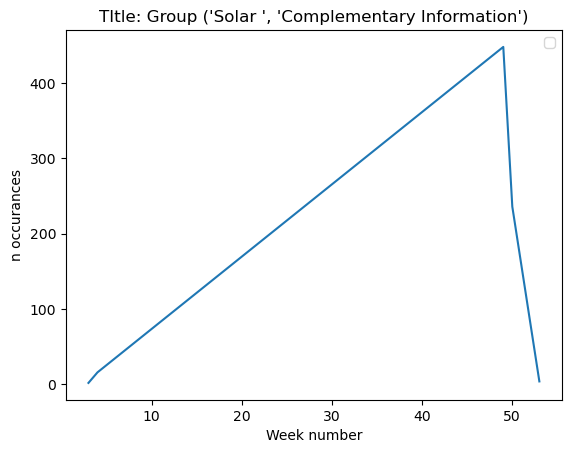

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


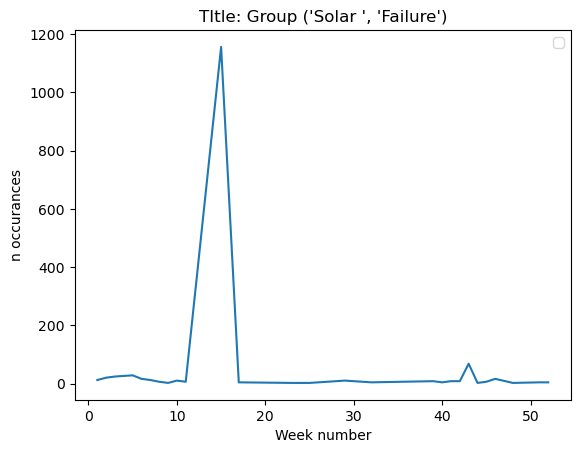

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


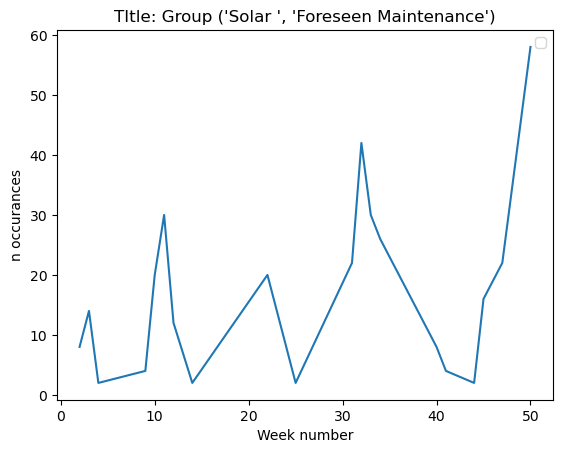

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


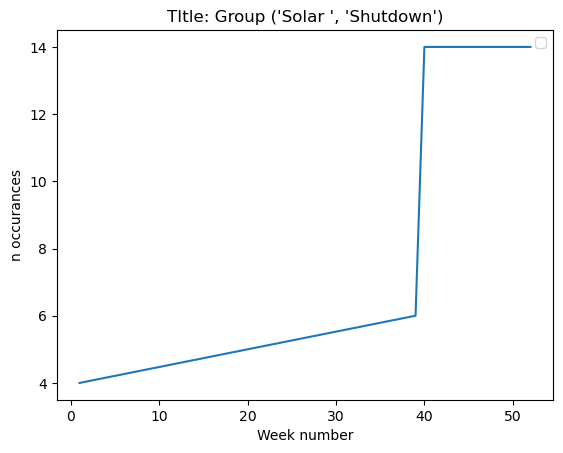

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


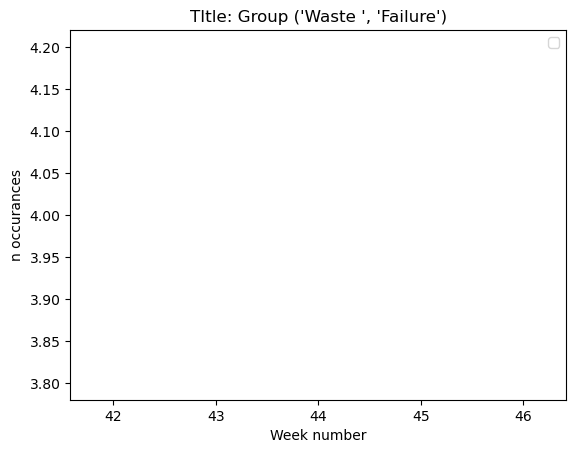

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


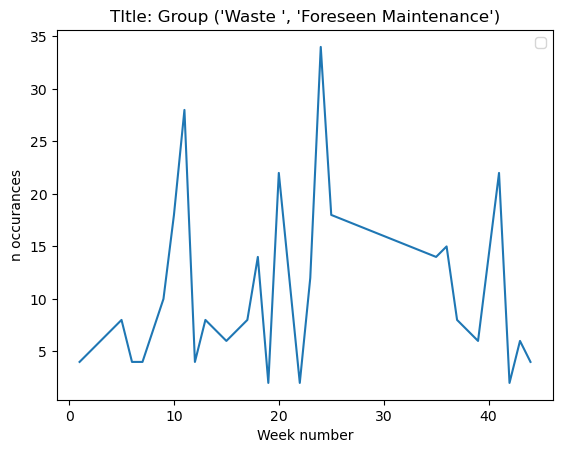

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


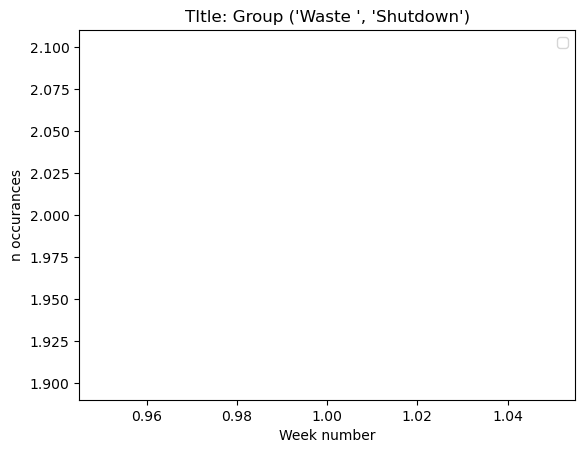

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


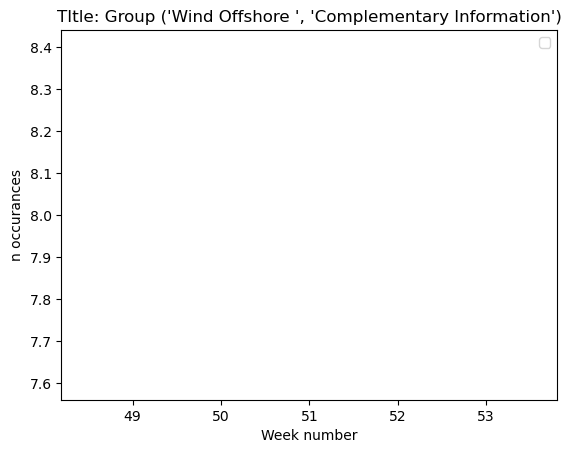

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


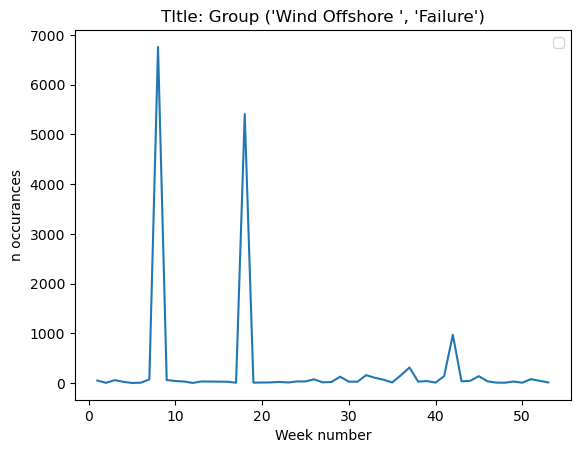

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


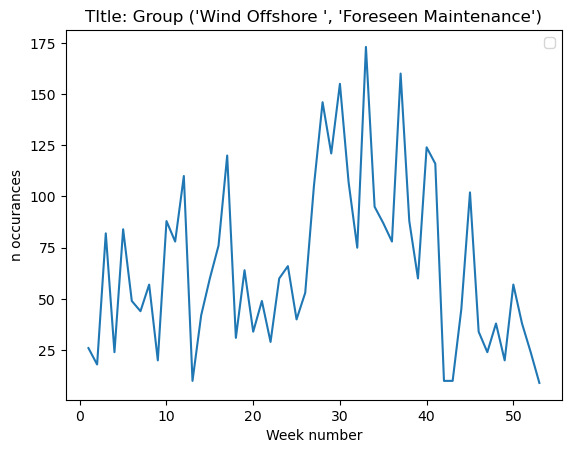

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


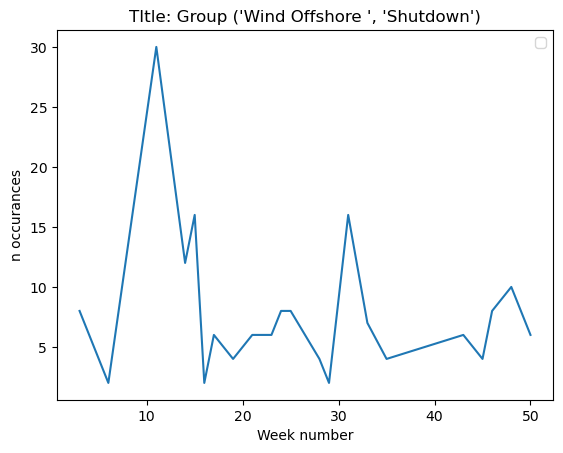

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


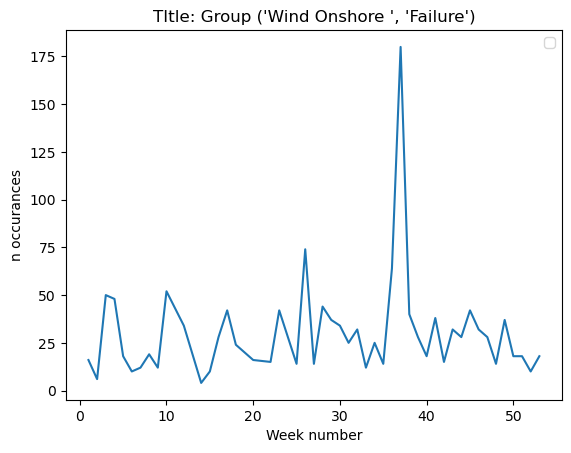

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


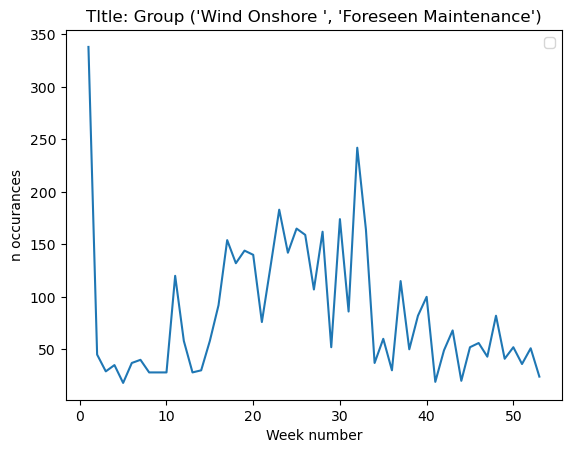

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


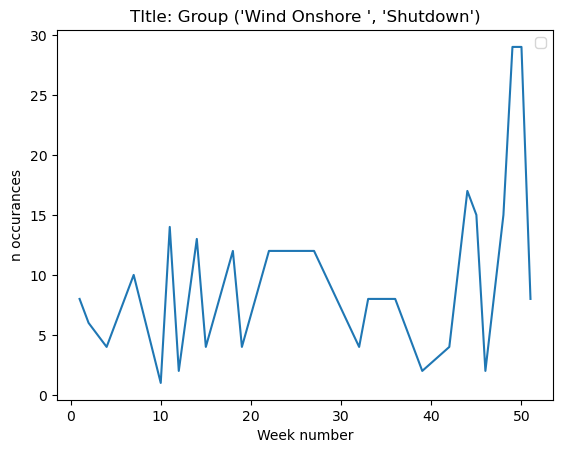

In [110]:
#calculate time spent in each state, fit with MLE and plot 


delta_df = df
delta_df = delta_df.sort_values(by = ["UnitName", "StartTS"])

#We calculate running time (uptime) before failure
for unit, unit_df in delta_df.groupby("UnitName"):
    shifted_endts = pd.to_datetime(np.array([np.datetime64("NaT")] + list(unit_df["EndTS"][:-1])))
    start_ts = delta_df.loc[delta_df["UnitName"] == unit, "StartTS"]
    delta_df.loc[delta_df["UnitName"] == unit, "UpTime"] = start_ts - shifted_endts
    
delta_df["OffTime"] = delta_df["EndTS"]-delta_df["StartTS"]
delta_df["UpTime"] = (delta_df["UpTime"] /  np.timedelta64(1, 's')) / (60 * 60 * 24)
delta_df["OffTime"] = (delta_df["OffTime"]  / np.timedelta64(1, 's')) / (60 * 60 * 24)

#fir outages distributions
params = pd.DataFrame()
grouped_delta = delta_df.groupby(["ProductionType"])
params["ProductionType"] = grouped_delta.first().reset_index()["ProductionType"]
params["up_scale"] = [np.nan]*len(list(params["ProductionType"]))
params["off_scale"] = [np.nan]*len(list(params["ProductionType"]))

def exponential_fit(x, scale):
    return expon.pdf(x, scale=scale)


for group_name, group_df in grouped_delta:
    
    #We drop NaN valued rows
    group_df = group_df.dropna(subset = ["UpTime","OffTime"])
    
    # Fit the data to the exponential function
    up_scale = 1/group_df["UpTime"].mean()
    off_scale = 1/group_df["OffTime"].mean()

    params.loc[params["ProductionType"] == group_name, "up_scale"] = up_scale
    params.loc[params["ProductionType"] == group_name, "off_scale"] = off_scale

    ## Uptime plot
    plt.figure()
    plt.hist(group_df["UpTime"], bins=500, edgecolor='black', density=True)
    # Plot the fitted exponential distribution
    x = np.sort(group_df["UpTime"])
    plt.plot(x, exponential_fit(x, up_scale), 'r-', label='Exponential Fit')
    plt.xlabel('Duration UpTime')
    plt.ylabel('Frequency')
    plt.title(f'UpTime {group_name}')
    plt.legend()
    plt.show()

    ## Offtime plot
    plt.figure()
    plt.hist(group_df["OffTime"], bins=500, edgecolor='black', density=True)
    # Plot the fitted exponential distribution
    x = np.sort(group_df["OffTime"])
    plt.plot(x, exponential_fit(x, off_scale), 'r-', label='Exponential Fit')
    plt.xlabel('Duration OffTime')
    plt.ylabel('Frequency')
    plt.title(f'OffTime {group_name}')
    plt.legend()
    plt.show()

## Notes
This kind of show us that it doesn't make sense to consider the outages as random variables with a gaussian distribution as:
1. It doesn't seem to follow a gaussian pattern

2. It would depend upon where I choose to start my year

3. Literature suggest modeling using as output of the random variable of the outage: time on (time the generato normally functions) and time off (time the generator is not working anymore). If more then two states are present we may consider modeling the random variables as a homogenous(?) markov chain 

4. Selection bias? I am only considering generators that do fail... Should I apply such distribution to every generator? Not if it increases the average number og generators that fail. ---) Might be made better if it considers it as a Markov Chain! (because we have planned repairs which I assume most generators have).

# Off Time, On Time modeling
For now we assume only two states: on and off.
We model OffTime and OnTime with two exponential distritbutions  using the maximul likelyhood estimator


In [ ]:
#def model_outage(repository, generator_type, reason):
#reason = "Failure"
#generator_type = "Solar "

delta_df = pd.DataFrame()
k = 0
for file_name in os.listdir(repository):
    complete_path = os.path.join(repository,file_name)
    df = import_df(complete_path)
    #df = df[(df["Reason" == reason]) & (df["ProductionType"] == generator_type)]
    #(cols, rows) = df.shape()
    if k%20 == 0
        print(k)
    delta_df = pd.concat([delta_df,df])

#delta_df = delta_df.sort_values(by = ["UnitName", "StartTS"])
#We may need to do this in the whole table (maybe doing one generato/country at the time and saving the results)
#or create an other table saving the data and delating the last instance for every generator once used.
delta_df = delta_df.sort_values(by = ["UnitName", "StartTS"])
delta_df["UpTime"] = delta_df.groupby("UnitName")["StartTS"].diff()
delta_df["OffTime"] = delta_df["EndTS"]-delta_df["StartTS"]
delta_df["UpTime"] = delta_df["UpTime"].dt.total_seconds() / (60 * 60 * 24)
delta_df["OffTime"] = delta_df["OffTime"].dt.total_seconds() / (60 * 60 * 24)
     




In [ ]:
#delta_df.to_csv("deltaFailure_df.csv", index = False)
delta_df = pd.read_csv("deltaWithEverything_df.csv",parse_dates = [0,1,16])

minutes = 60
#print(f"Number of time machinery lasted less than {minutes} minutes: {delta_df[delta_df['UpTime'] < minutes/(60*24)]['UpTime'].count()} on a total of {delta_df['UpTime'].count()} periods that is {delta_df[delta_df['UpTime'] < minutes/(60*24)]['UpTime'].count()/delta_df['UpTime'].count()} %")

delta_df = delta_df.sort_values(by = ["StartTS"])
delta_df.tail()


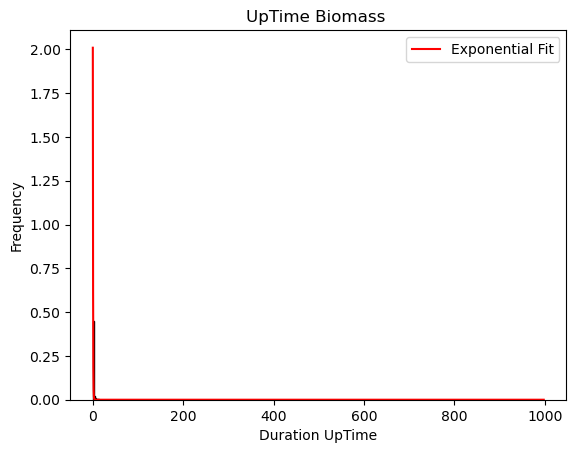

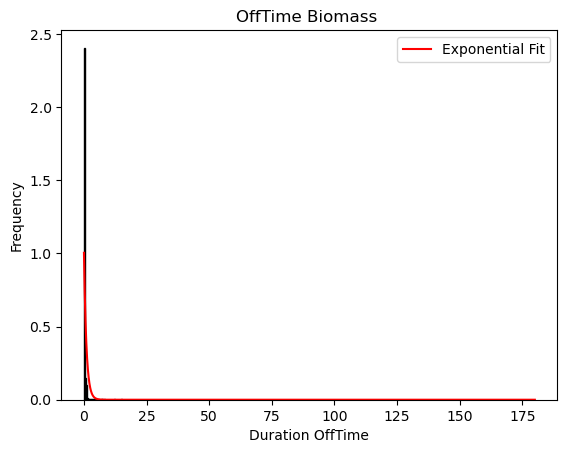

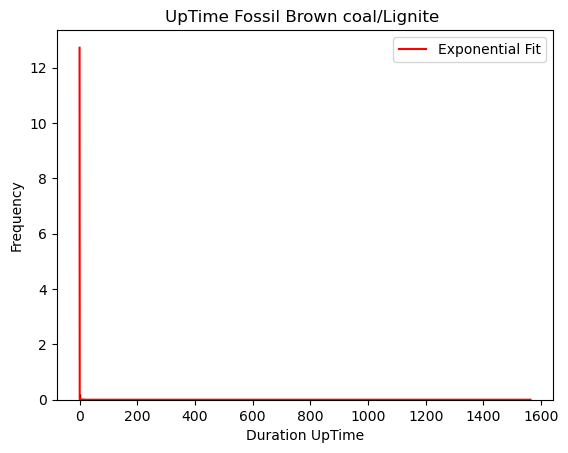

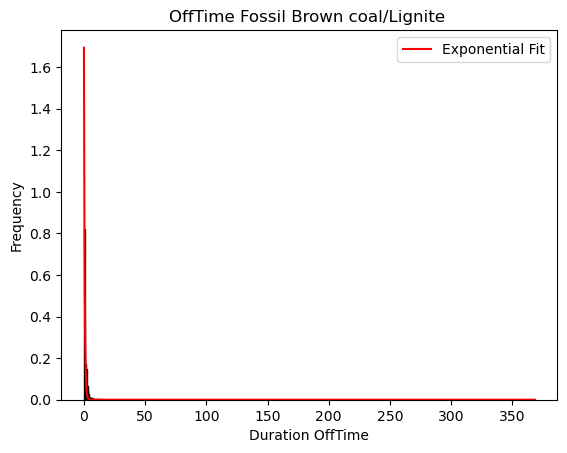

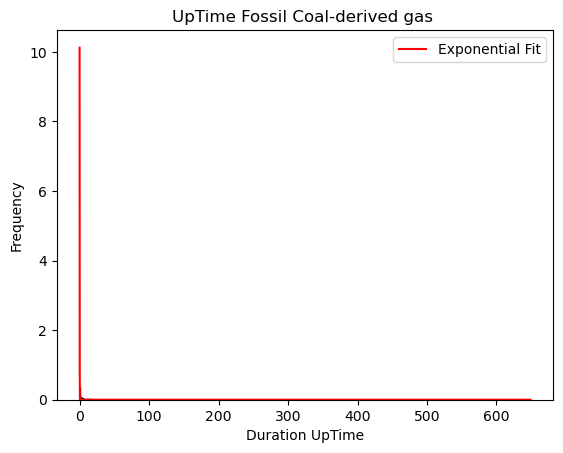

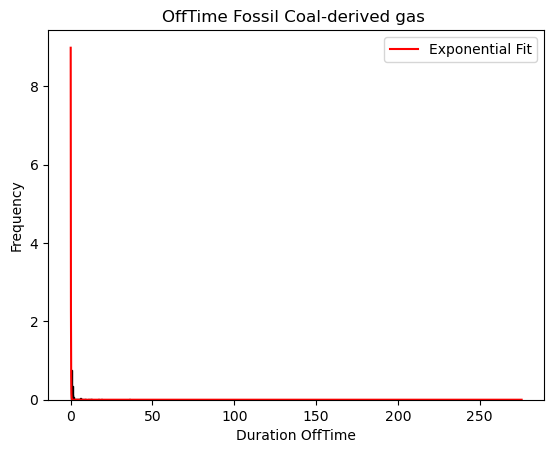

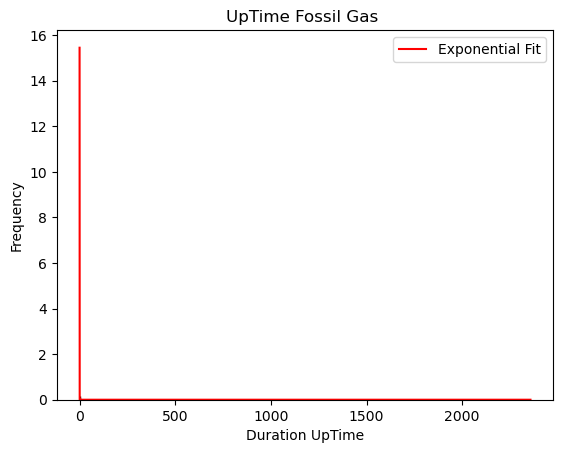

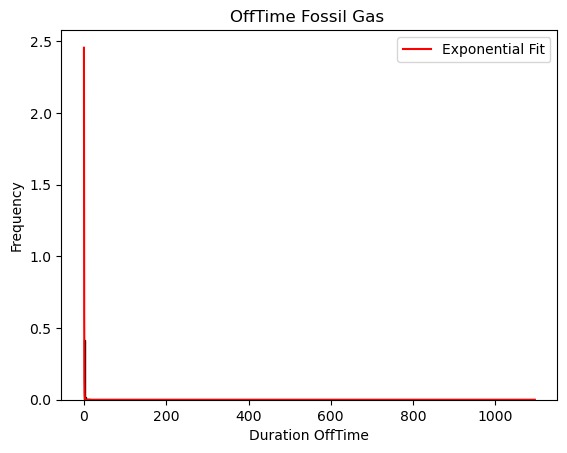

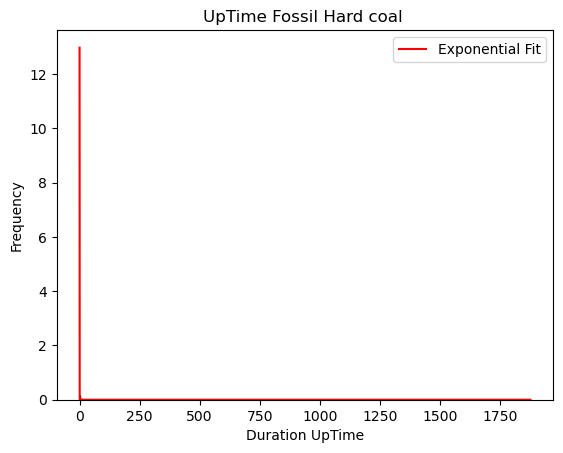

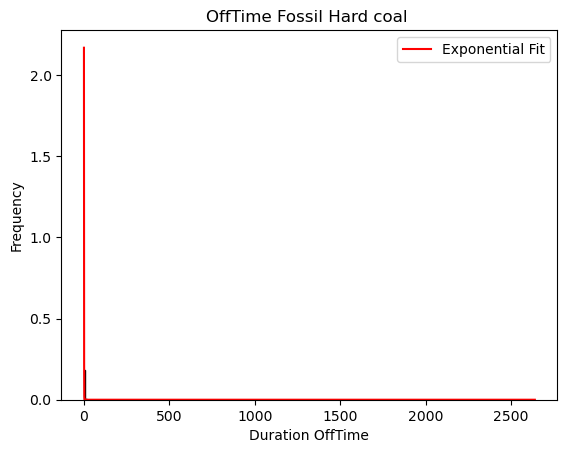

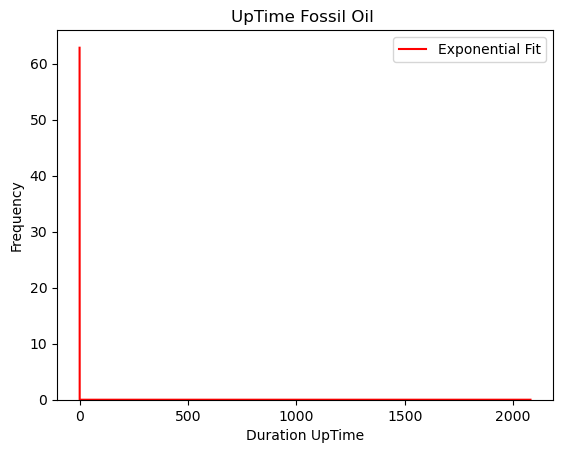

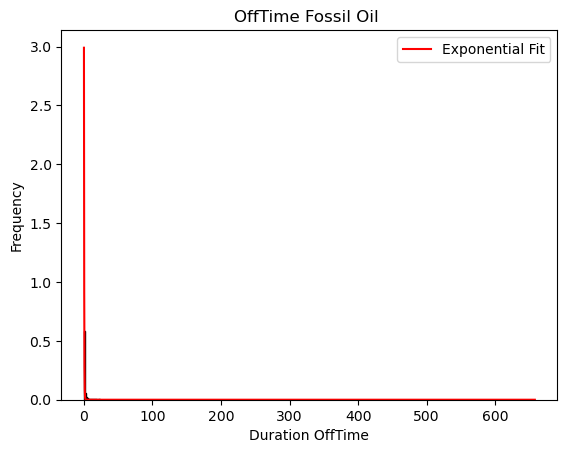

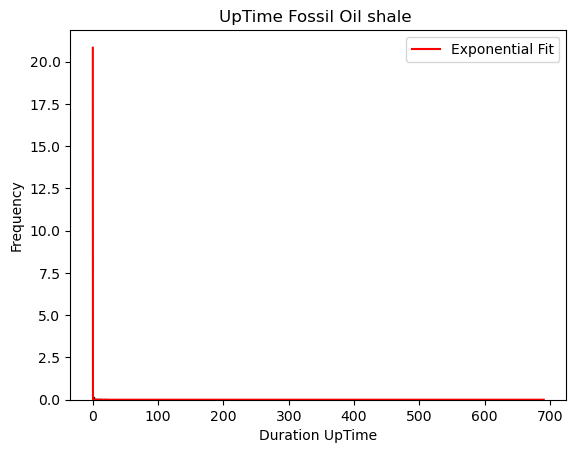

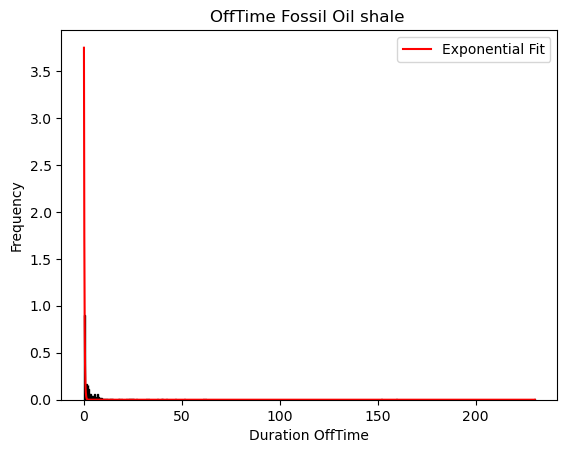

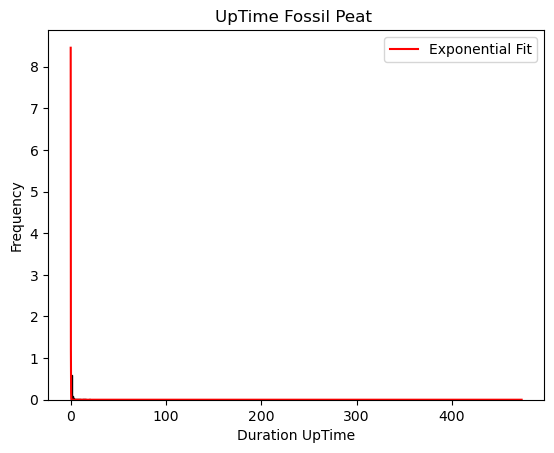

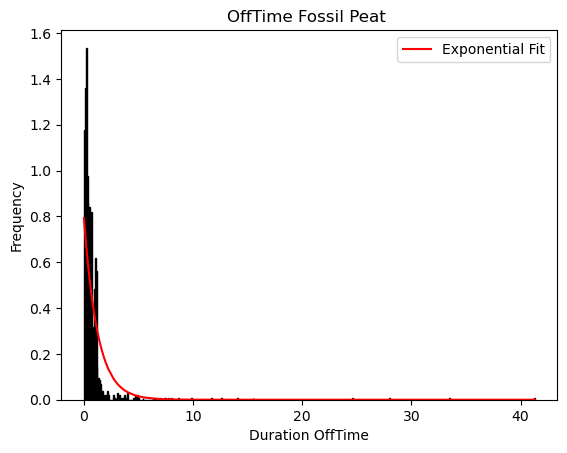

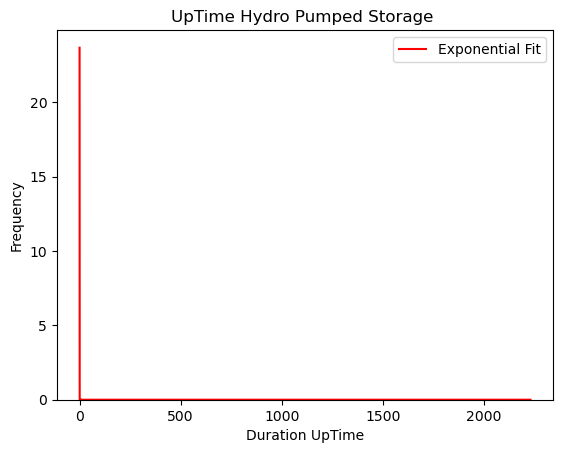

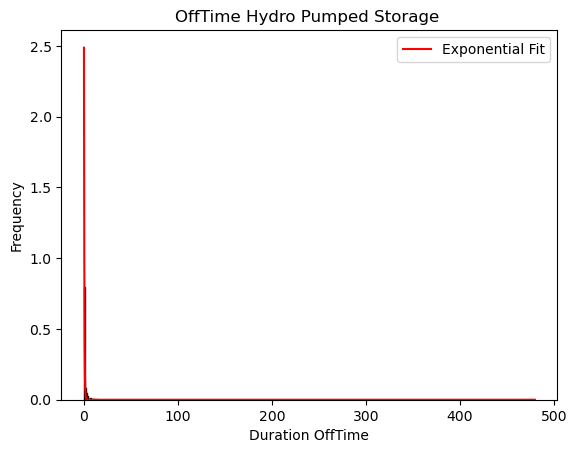

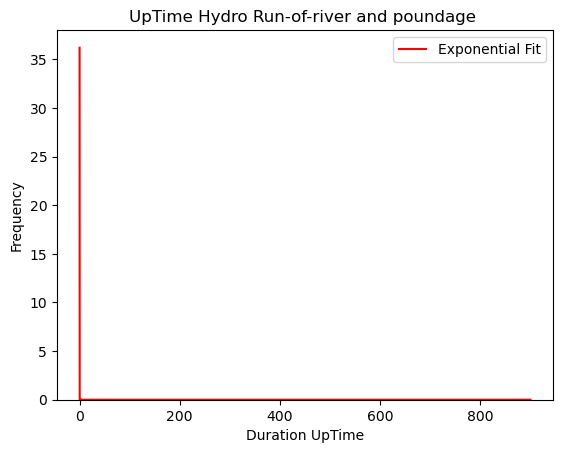

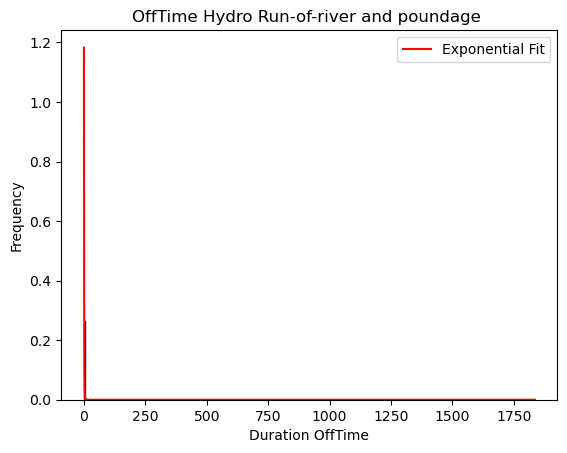

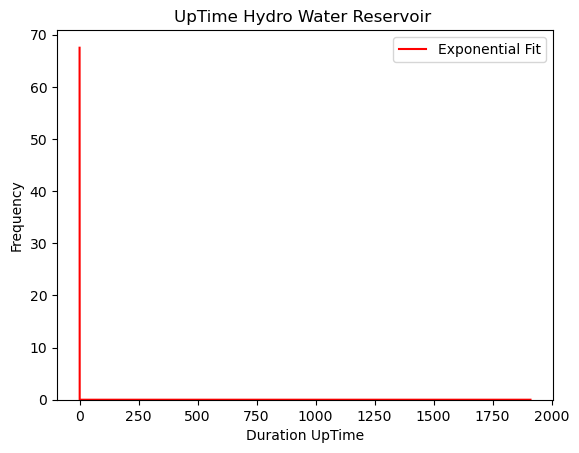

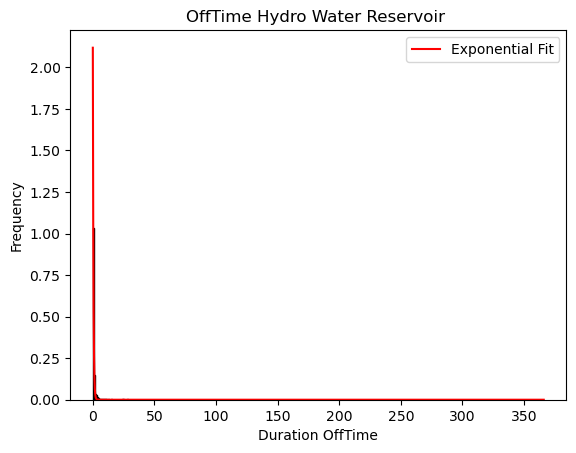

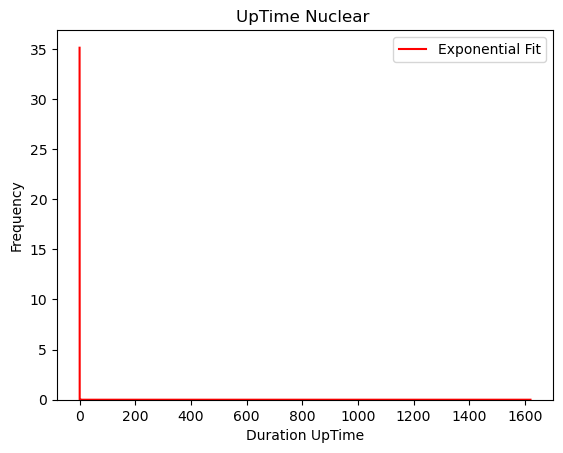

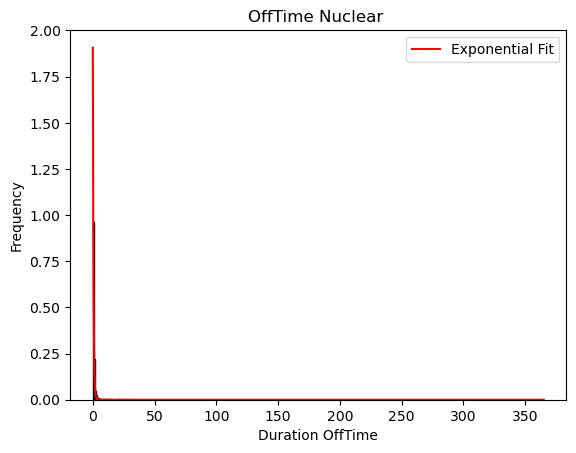

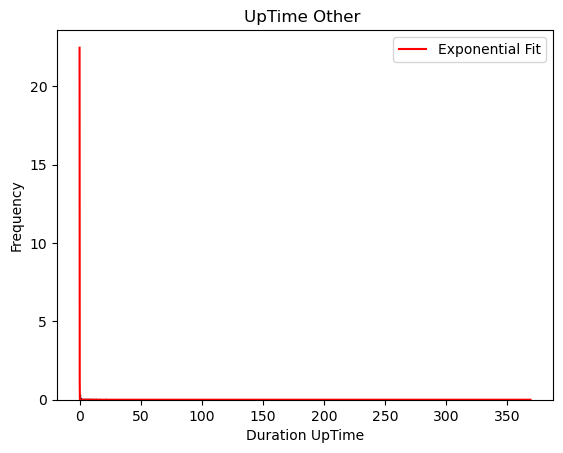

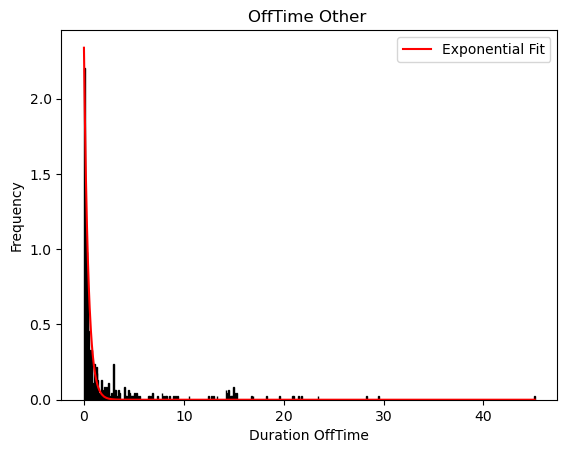

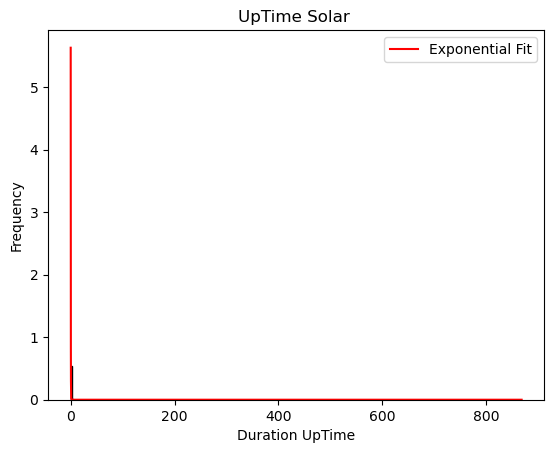

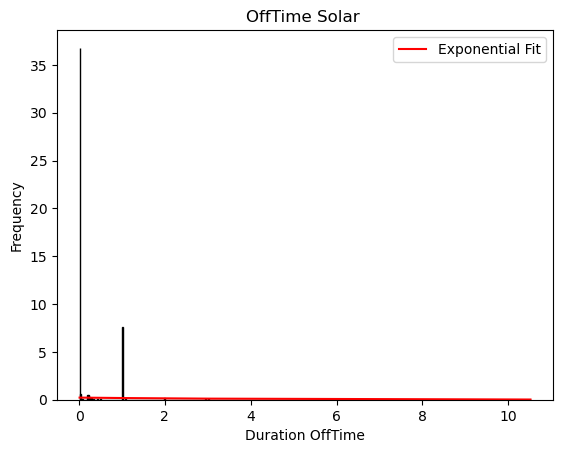

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


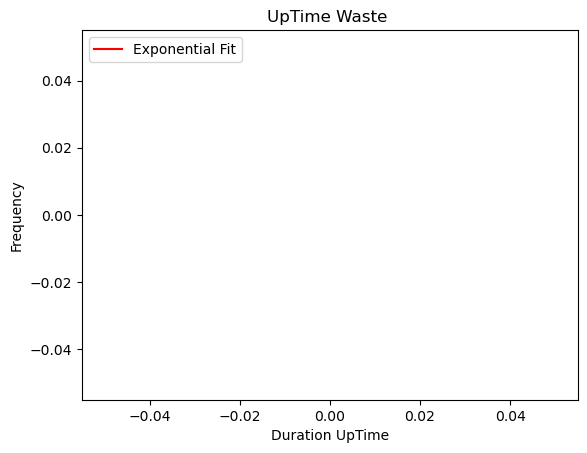

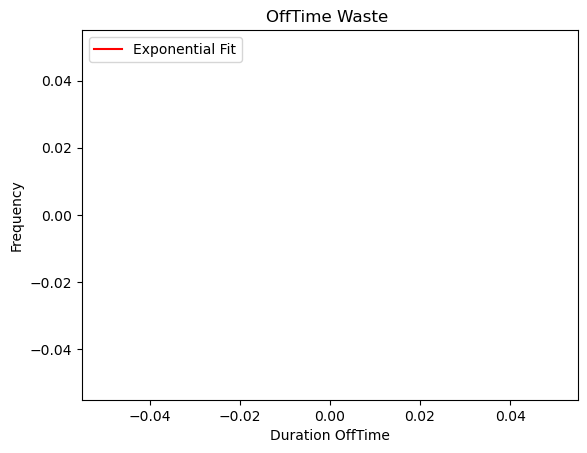

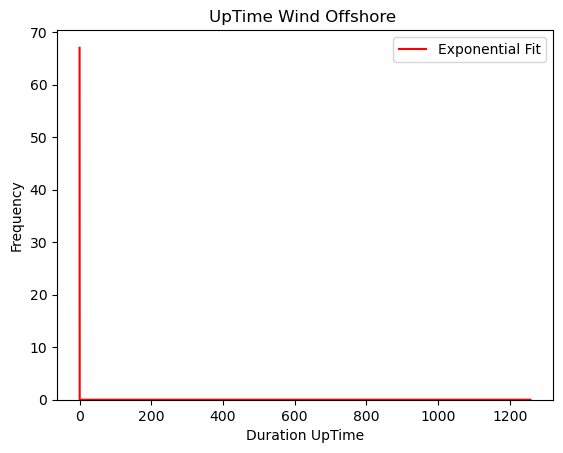

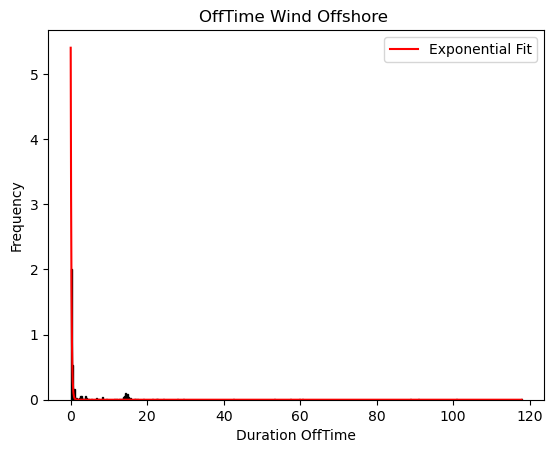

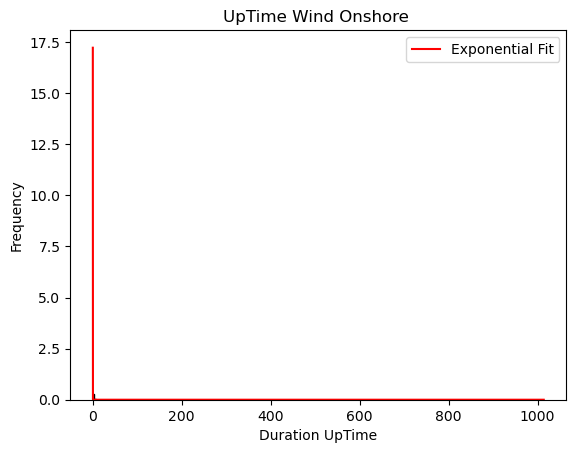

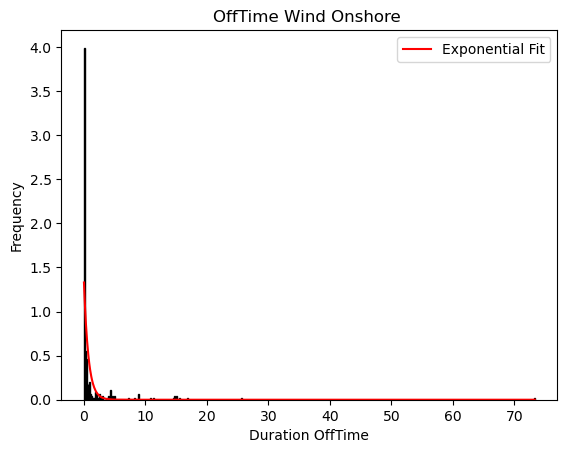

In [63]:
#Maximum Likelyhood estimator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.optimize import curve_fit


params = pd.DataFrame()
grouped_delta = delta_df.groupby(["ProductionType"])
params["ProductionType"] = grouped_delta.first().reset_index()["ProductionType"]
params["up_scale"] = [np.nan]*len(list(params["ProductionType"]))
params["off_scale"] = [np.nan]*len(list(params["ProductionType"]))


def exponential_fit(x, scale):
    return expon.pdf(x, scale=scale)

for group_name, group_df in grouped_delta:
    
    #We drop NaN valued rows
    group_df = group_df.dropna(subset = ["UpTime","OffTime"])
    
    # Fit the data to the exponential function
    up_scale = 1/group_df["UpTime"].mean()
    off_scale = 1/group_df["OffTime"].mean()

    params.loc[params["ProductionType"] == group_name, "up_scale"] = up_scale
    params.loc[params["ProductionType"] == group_name, "off_scale"] = off_scale

    ## Uptime plot
    plt.figure()
    plt.hist(group_df["UpTime"], bins=500, edgecolor='black', density=True)
    # Plot the fitted exponential distribution
    x = np.sort(group_df["UpTime"])
    plt.plot(x, exponential_fit(x, up_scale), 'r-', label='Exponential Fit')
    plt.xlabel('Duration UpTime')
    plt.ylabel('Frequency')
    plt.title(f'UpTime {group_name}')
    plt.legend()
    plt.show()

    ## Offtime plot
    plt.figure()
    plt.hist(group_df["OffTime"], bins=500, edgecolor='black', density=True)
    # Plot the fitted exponential distribution
    x = np.sort(group_df["OffTime"])
    plt.plot(x, exponential_fit(x, off_scale), 'r-', label='Exponential Fit')
    plt.xlabel('Duration OffTime')
    plt.ylabel('Frequency')
    plt.title(f'OffTime {group_name}')
    plt.legend()
    plt.show()


C:\Program Files\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Program Files\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2085: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


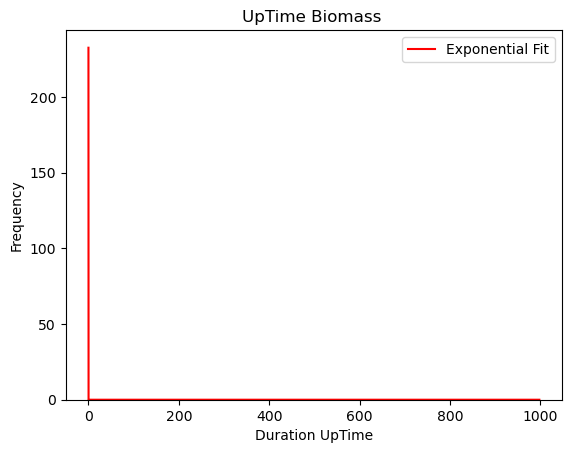

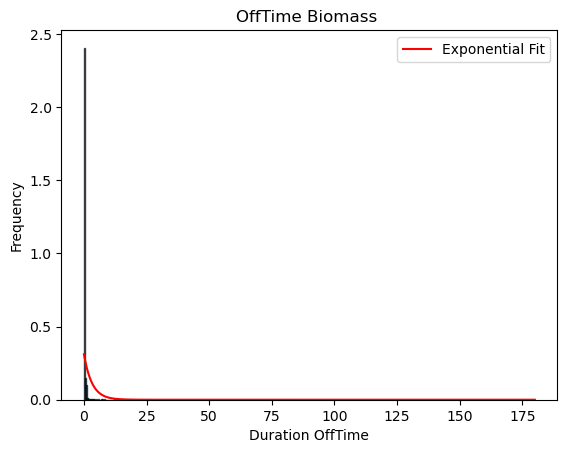

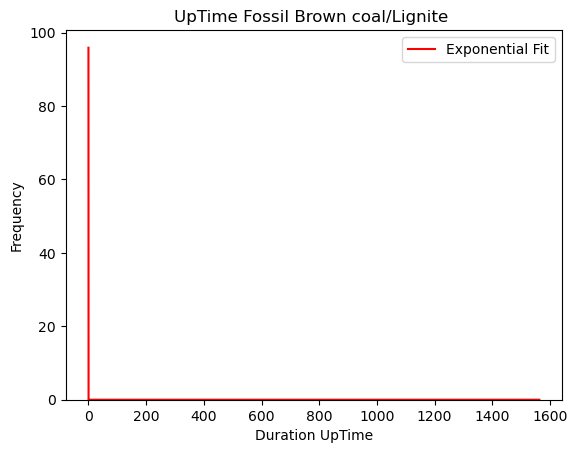

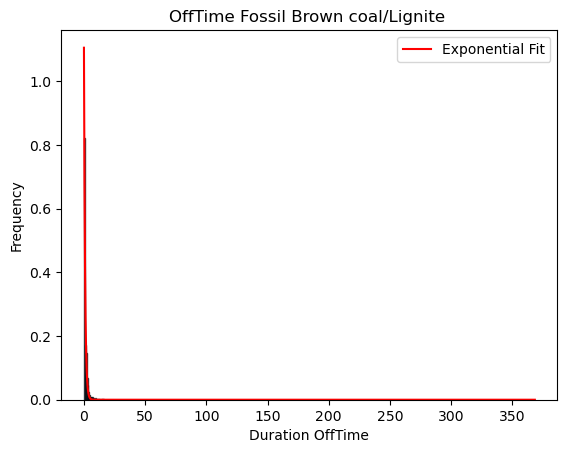

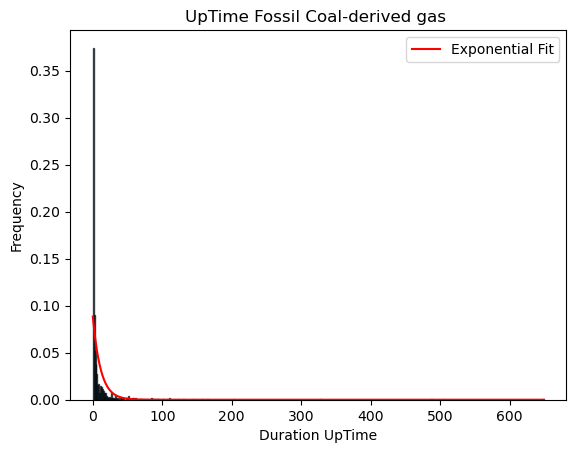

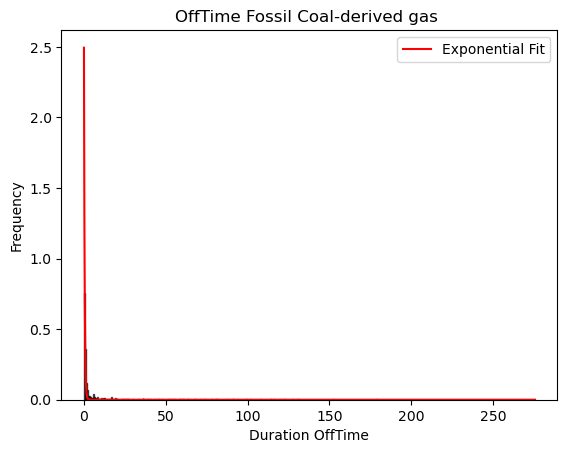

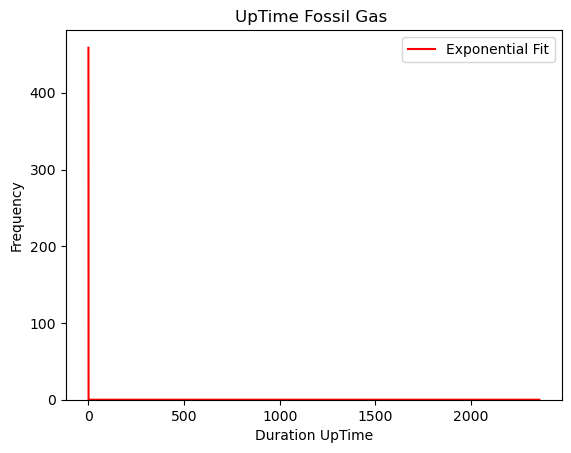

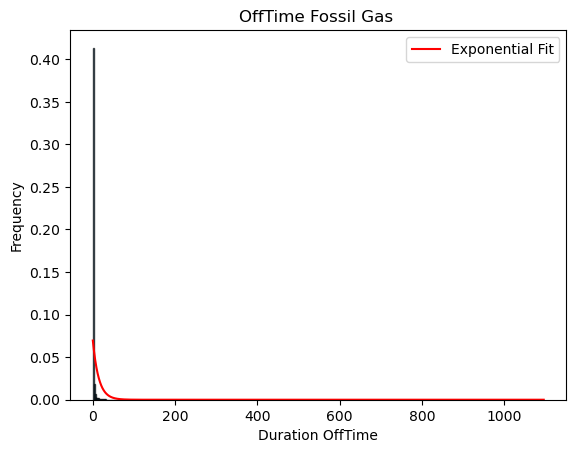

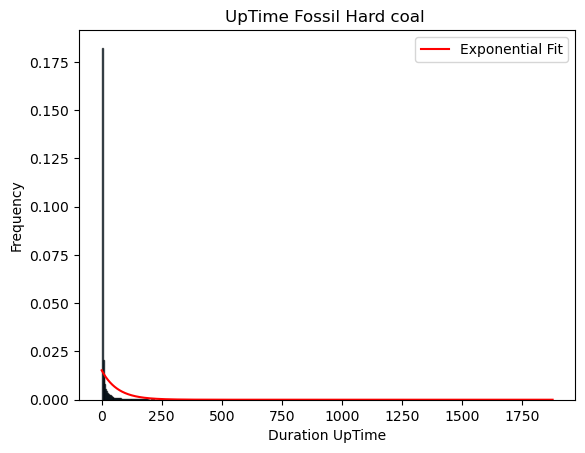

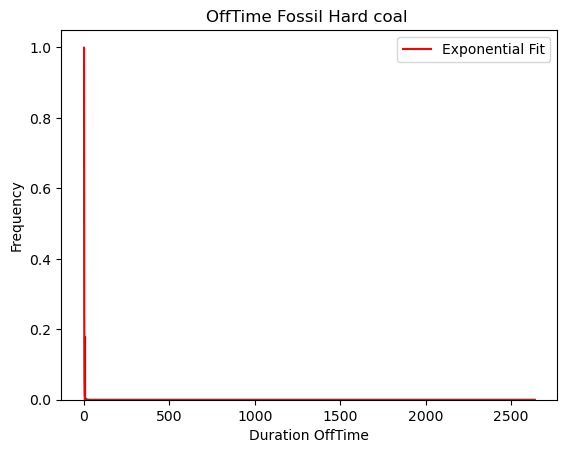

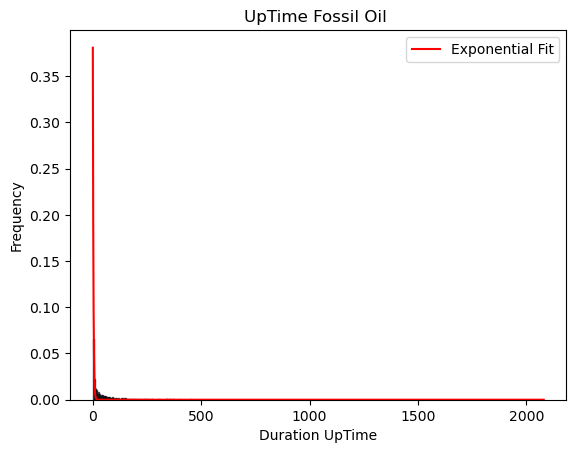

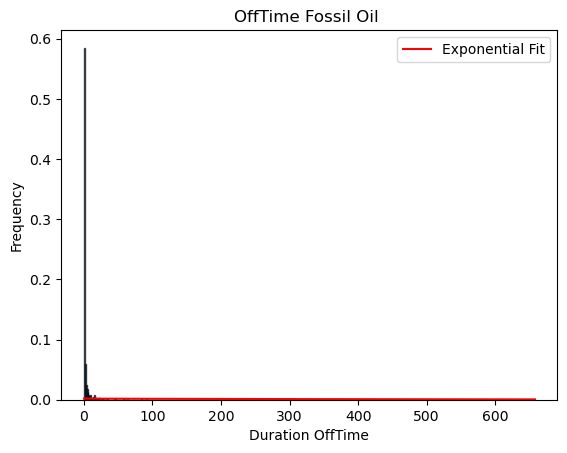

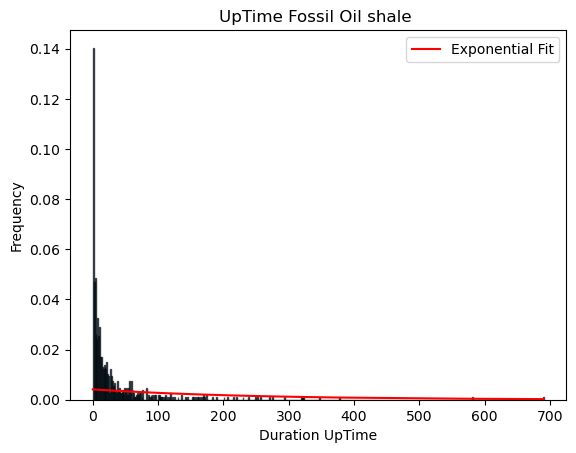

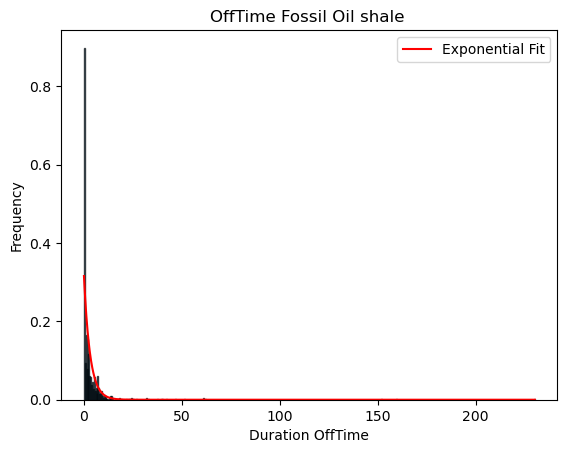

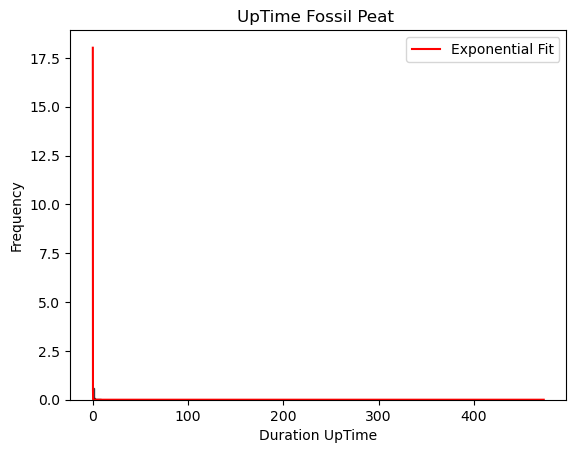

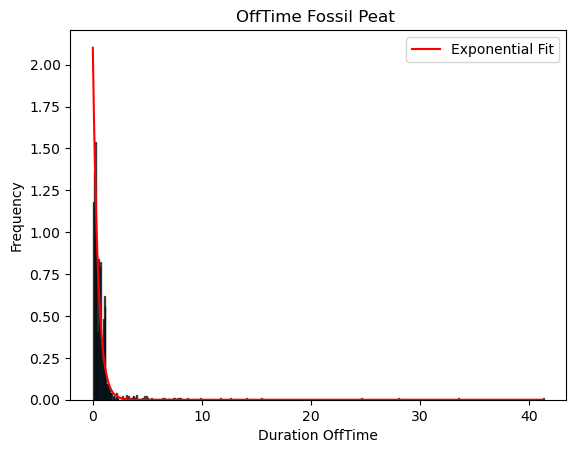

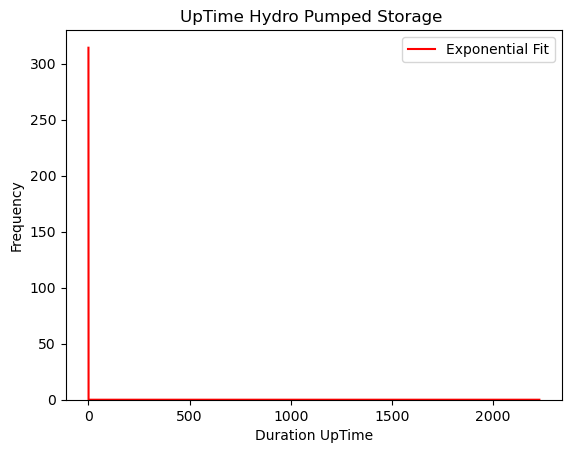

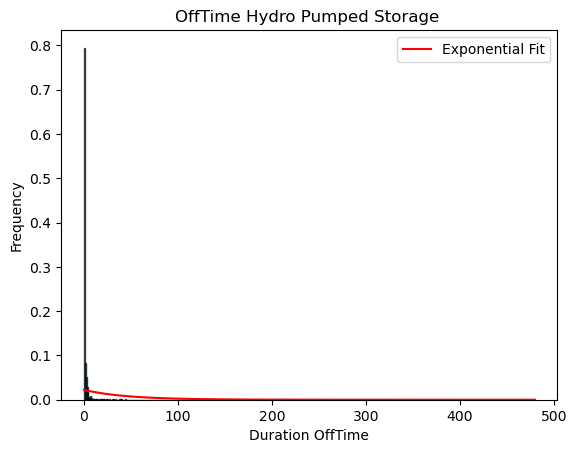

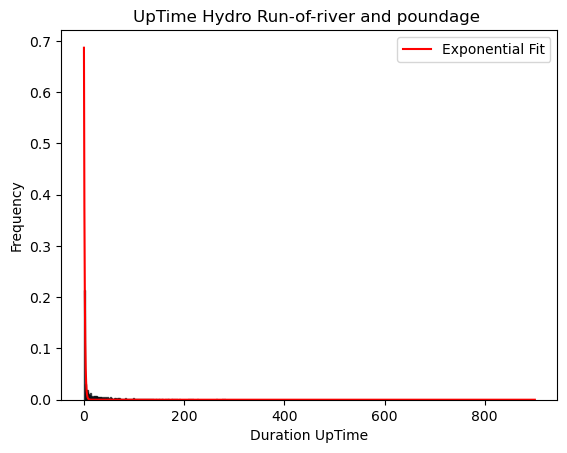

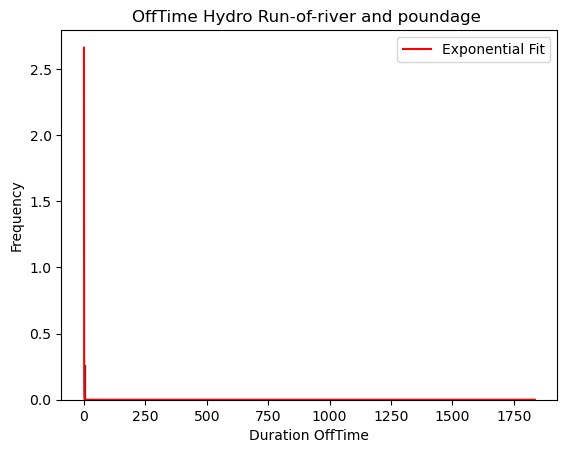

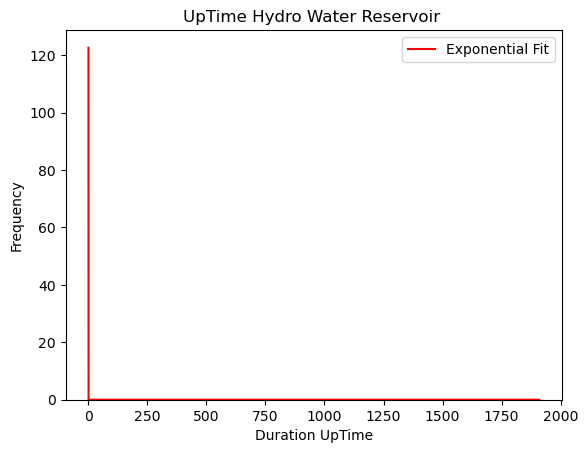

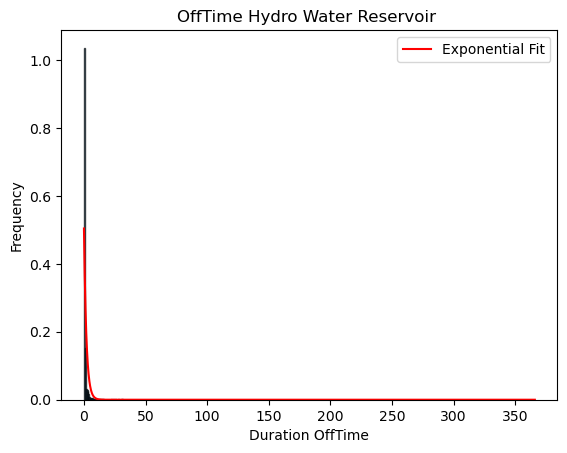

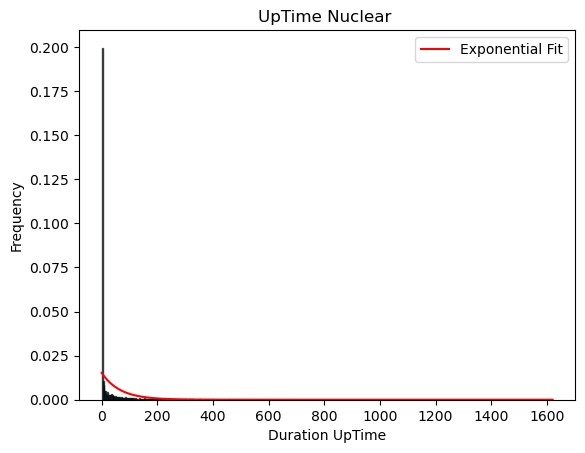

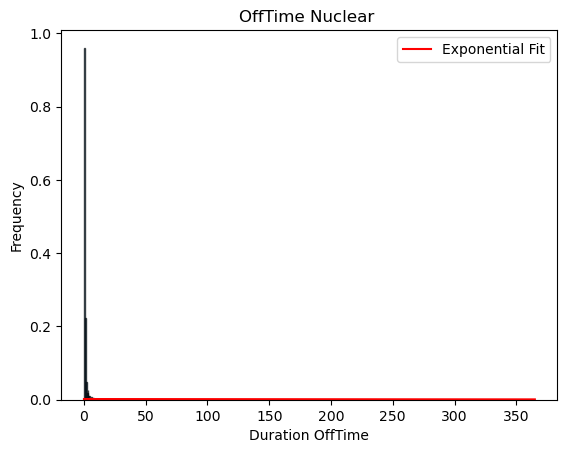

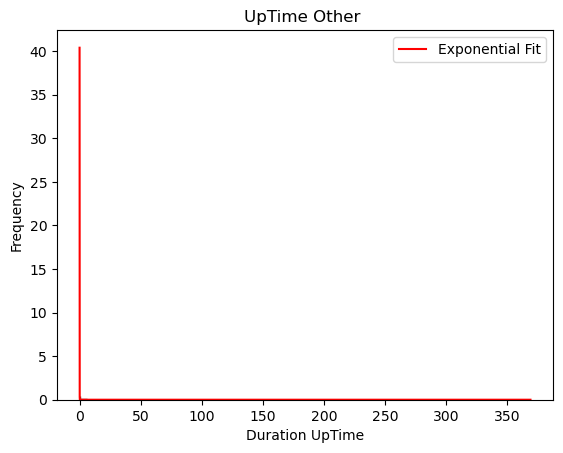

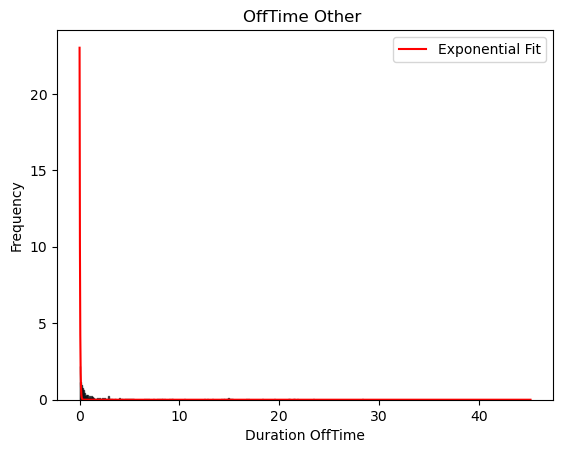

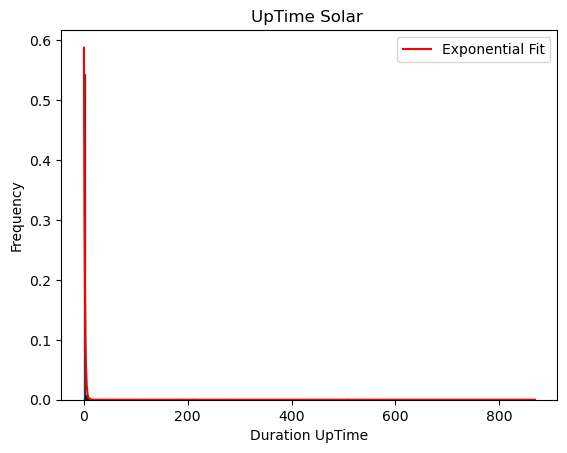

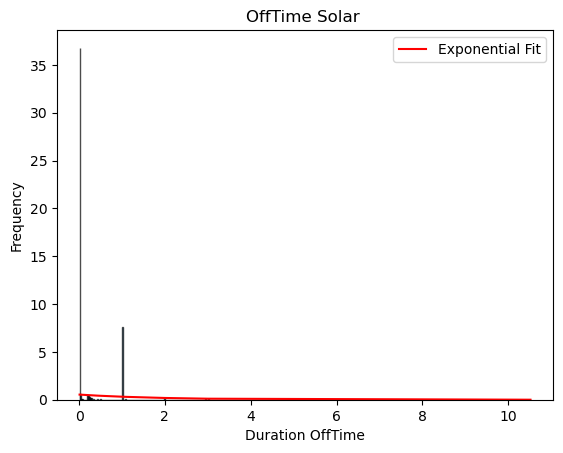

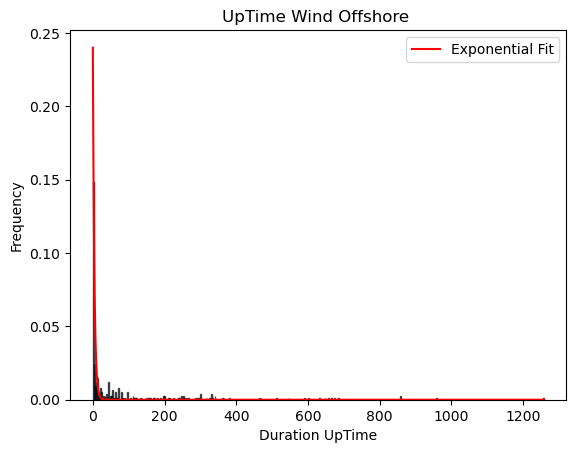

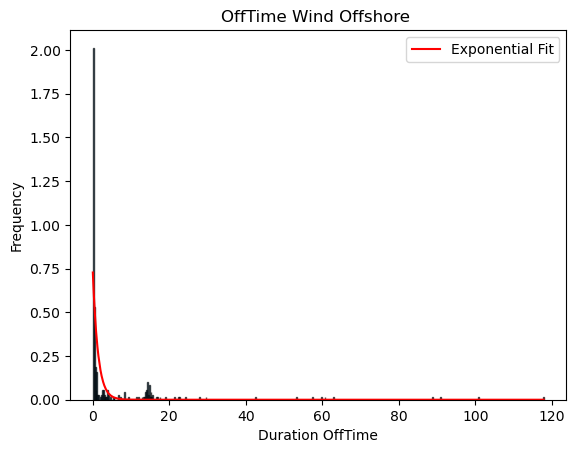

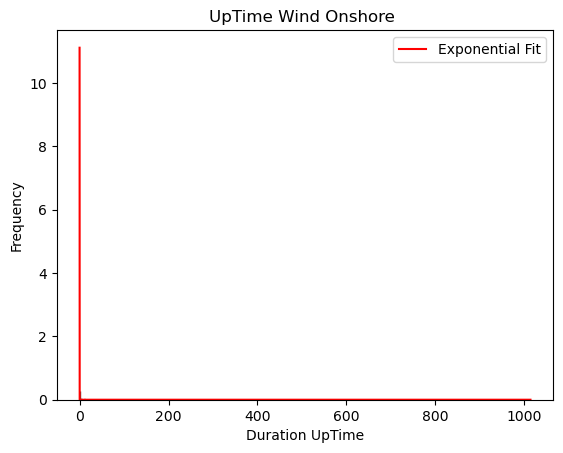

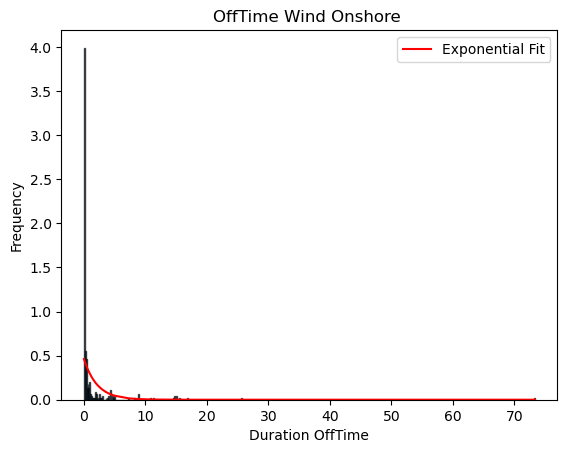

In [67]:
#with curve_fit ---) linear least square to fit function to data
#todo: fit it to histrogram not to data directly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.optimize import curve_fit


params = pd.DataFrame()
grouped_delta = delta_df.groupby(["ProductionType"])
params["ProductionType"] = grouped_delta.first().reset_index()["ProductionType"]
params["up_scale"] = [np.nan]*len(list(params["ProductionType"]))
params["off_scale"] = [np.nan]*len(list(params["ProductionType"]))

# Assuming 'delta_df' and 'params' are already defined

def exponential_fit(x, scale):
    return expon.pdf(x, scale=scale)

for group_name, group_df in grouped_delta:
    
    #We drop NaN valued rows
    group_df = group_df.dropna(subset = ["UpTime","OffTime"])
    
    if group_df.shape[0] != 0:
        # Fit the data to the exponential function
        up_scale, up_covariance = curve_fit(exponential_fit, xdata=np.arange(len(group_df["UpTime"])), ydata=group_df["UpTime"])
        off_scale, up_covariance = curve_fit(exponential_fit, xdata=np.arange(len(group_df["OffTime"])), ydata=group_df["OffTime"])
        up_scale, off_scale = (up_scale[0], off_scale[0])

        params.loc[params["ProductionType"] == group_name, "up_scale"] = up_scale
        params.loc[params["ProductionType"] == group_name, "off_scale"] = off_scale

        ## Uptime plot
        plt.figure()
        plt.hist(group_df["UpTime"], bins=500, edgecolor='black', alpha=0.7, density = True)
        # Plot the fitted exponential distribution
        x = np.sort(group_df["UpTime"])
        plt.plot(x, exponential_fit(x, up_scale), 'r-', label='Exponential Fit')
        plt.xlabel('Duration UpTime')
        plt.ylabel('Frequency')
        plt.title(f'UpTime {group_name}')
        plt.legend()
        plt.show()

        ## Offtime plot
        plt.figure()
        plt.hist(group_df["OffTime"], bins=500, edgecolor='black', alpha=0.7, density = True)
        # Plot the fitted exponential distribution
        x = np.sort(group_df["OffTime"])
        plt.plot(x, exponential_fit(x, off_scale), 'r-', label='Exponential Fit')
        plt.xlabel('Duration OffTime')
        plt.ylabel('Frequency')
        plt.title(f'OffTime {group_name}')
        plt.legend()
        plt.show()


# Markov Chain modeling
In reality we may have more states: 
- On
- Off
- Mai (Maintenance) <br>
We can model the passage from one state to an other as a Homogeneous Markov State:
that is givens a state S1 we model the probability of going to each of the states: On, Off, Mai
and we assume this probability does not depend upon the states before S1.
Idea: if we have a failure (S1 = On) the probability to going into (Mai) may be higher than the probability of going to (Off).
Furthermore for each possible state stransition (S1 -) S2) we can model a random variable (t_{S1,S2}) which tell us how long it will stay in S2. The idea is that it may be more likey that a machine stays **On** longer after **Mai** than after **Off**

Workflow:
0. Which states make it work at reduced capacity?
1. How to model reduced capacity? (more states ---) higher complexity)
2. Count number of state changes
3. Calculate Markov chaing probability matrix
4. Calculate State times.

###### todos:
1. -- Maintenance is at fixed intervals? --
2. Markov modeling:
    2.1. Only with: Running, Forced, Planned
    2.2. With Running, Failure, Forced, Planned
    2.3. Additional info is always after failure? (Should be seen from 3.1)
3. Capacity modeling
4. Group by countries (later)
5. Use forced/planned instead?
6. Tests to measure best model? If possible
7. Remove rows after 2022
8. Confront if failures affect planned maintenance


### Maintenance modeling: todo number 1
Is maintenance for each generator at fixed time intervals?

Conclusione:
There seem to be some regularity in some of the generators but it's not clear to me how we could model it
###### totododo:
    1. Maybe If I look at the distribution of the time differences?

In [62]:
#Workflow: Zero
data = pd.read_csv("deltaWithEverything_df.csv",parse_dates = [0, 1, 16])
data = data.drop_duplicates(subset = ["UnitName", "StartTS"])

str

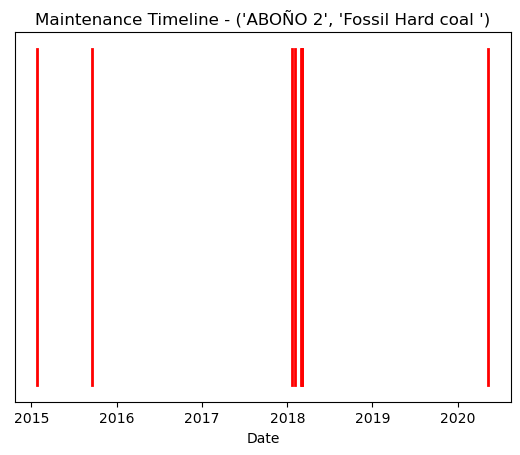

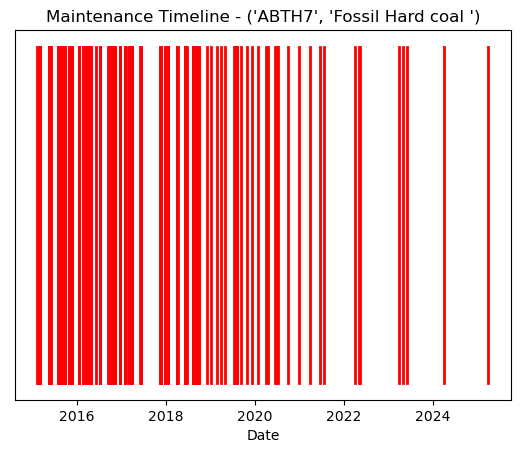

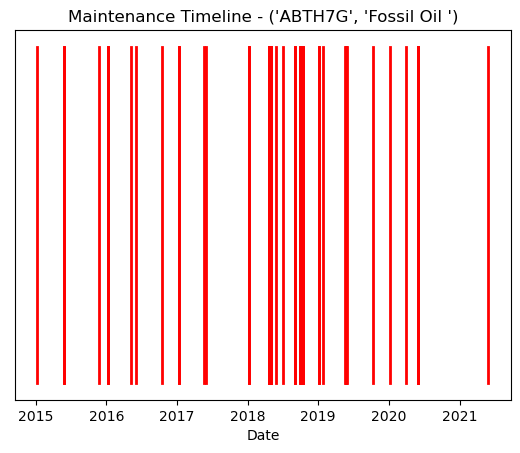

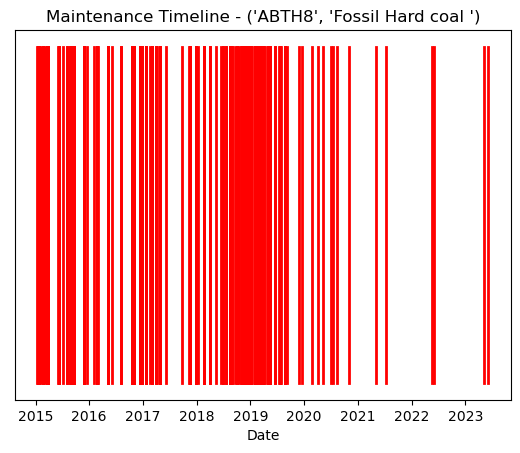

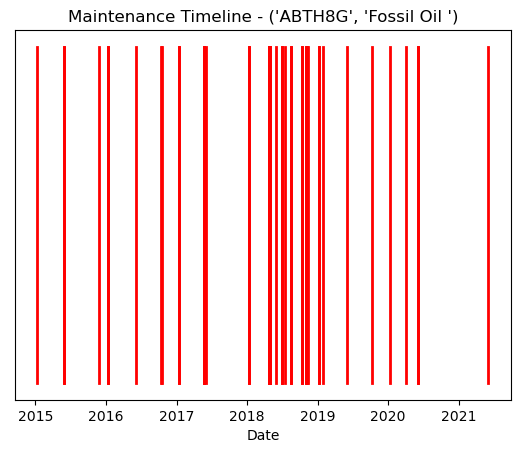

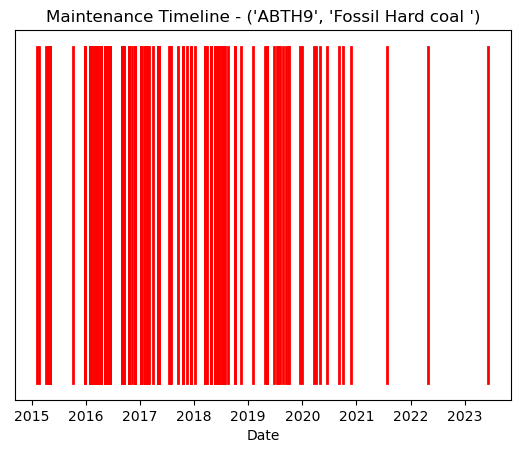

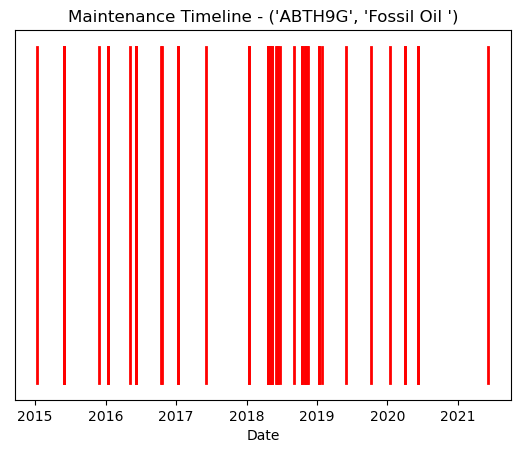

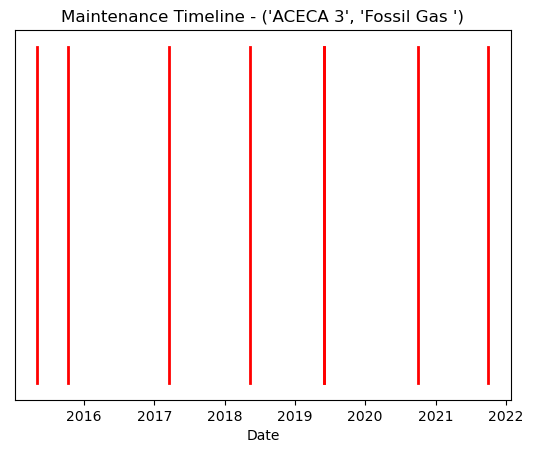

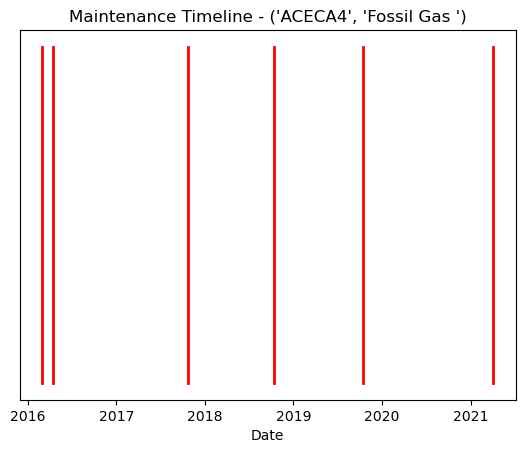

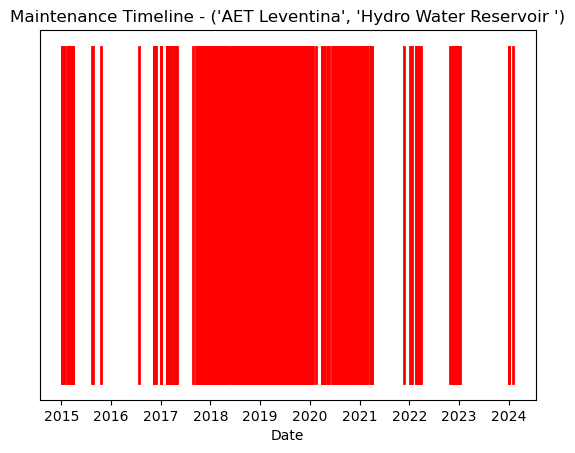

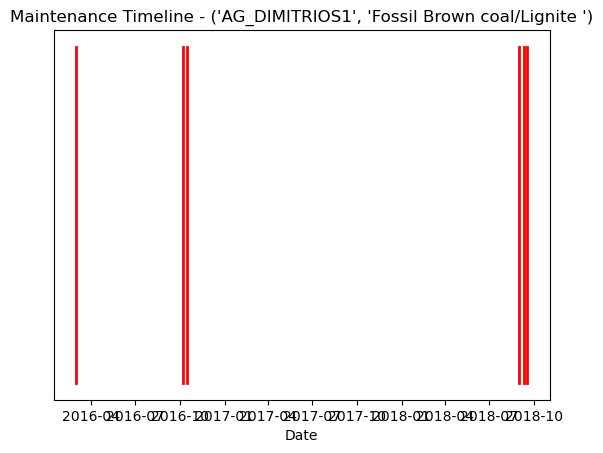

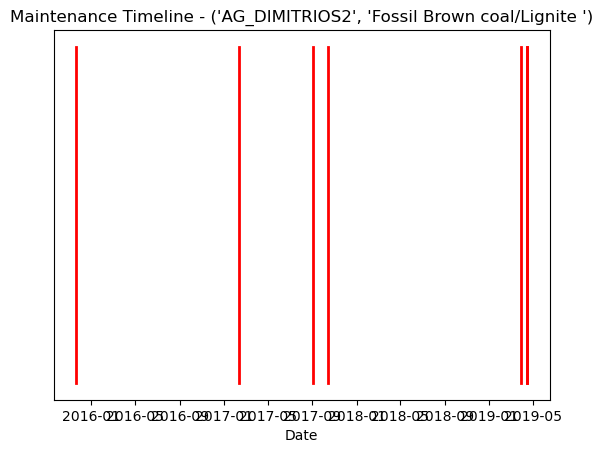

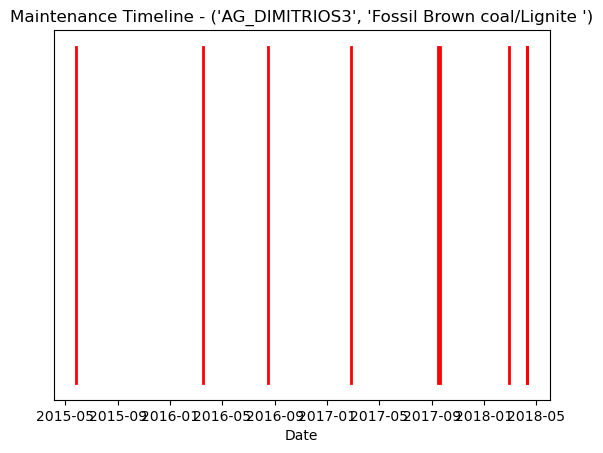

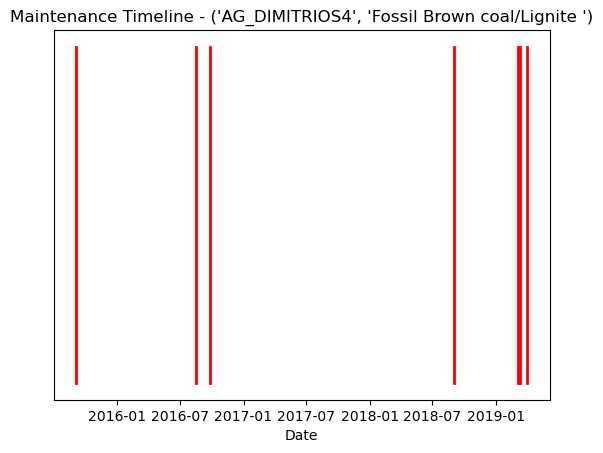

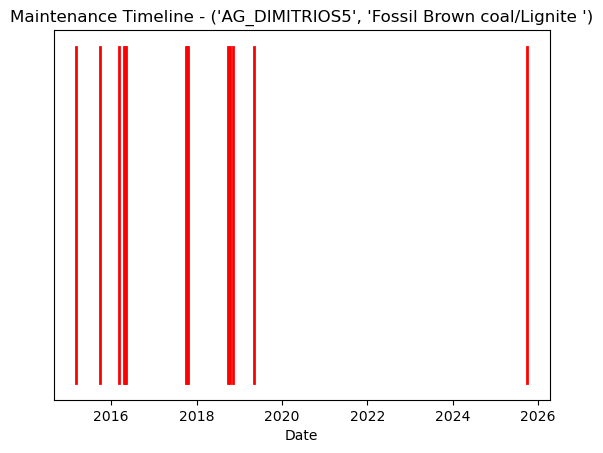

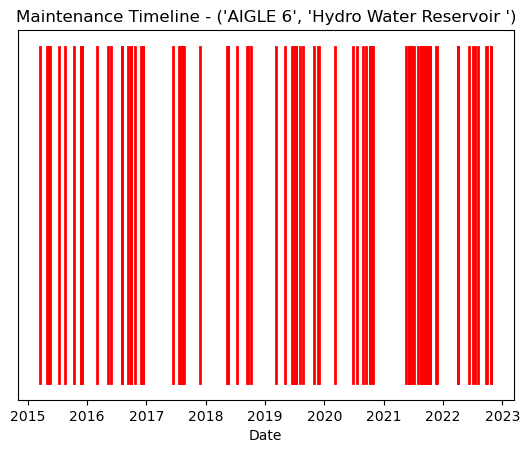

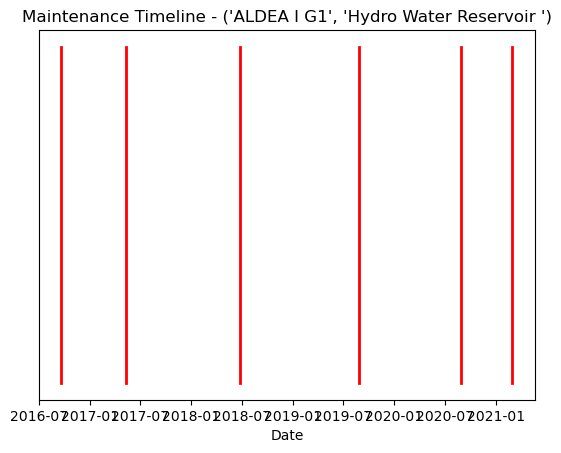

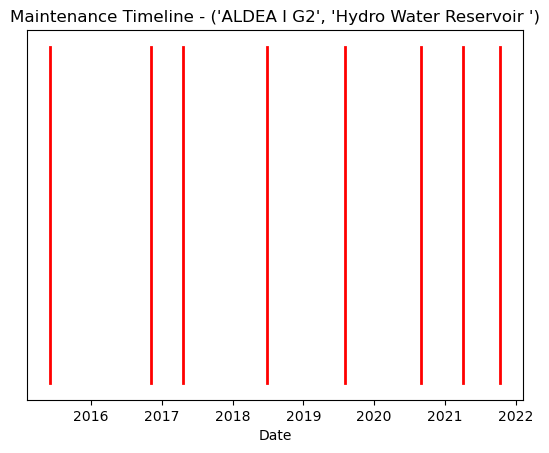

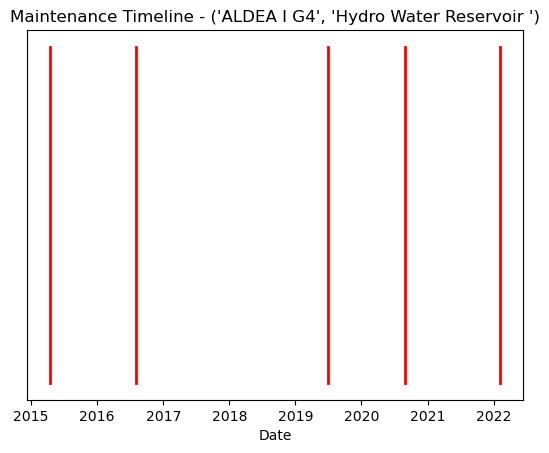

In [64]:
maintenance_df = data[data["Reason"] == "Foreseen Maintenance"].sort_values(by = ["UnitName","StartTS"])
#maintenance_df[["StartTS","EndTS","UnitName"]].groupby(["UnitName"]).head(2)
#maintenance_df.groupby(["UnitName"]).head(2)
maintenance_df["Delta Maintenance"] = maintenance_df.groupby("UnitName")["StartTS"].diff() # time passed from the previous maintenance
maintenance_df = maintenance_df.groupby("UnitName").filter(lambda x: len(x) > 4).reset_index() #take only generators with enough maintenance to see a pattern


k = 0
for unit_name , group_df in maintenance_df.groupby(["UnitName"]):
    unit_type = group_df["ProductionType"].iloc[0]
    plotted_types = []
    if k < 19 and unit_type not in plotted_types:
        
        plotted_types.append(unit_type)
        k = k+1
        plt.figure()  # Create a new figure for each UnitName
        for index, row in group_df.iterrows():
            plt.plot([row['StartTS'], row['StartTS']], [0, 1], color='red', linewidth=2)  # Adjust [0, 1] to set the height of the spike

        # Customize the plot
        plt.yticks([])  # Hide y-axis ticks
        plt.xlabel('Date')
        plt.title(f'Maintenance Timeline - {unit_name, unit_type}')
        plt.show()
        

# Show the plots


##### Markov modeling: todo number 2
Example:
**States: Running (in-between state), Planned Maintenance, Failure, Additional Information.**

todo:
- Do it for states: Forced, Planned, Running

In [211]:
#Workflow: Zero
data = pd.read_csv("deltaWithEverything_df.csv",parse_dates = [0, 1, 16])
data = data.drop_duplicates(subset = ["UnitName", "StartTS"])
data["UpTime"] = pd.to_timedelta(data["UpTime"])
data = data[data["Reason"] != "Shutdown" ]

In [212]:
data["Reason"].unique()

array(['Failure', 'Complementary Information', 'Foreseen Maintenance'],
      dtype=object)

In [213]:
#Create a list containing tuples rapresenting all possible state changes (x,y) := x --> y
#data is a dataframe containing the correct "UpTime" between the states considered
states = list(data["Reason"].unique())
states.append("Running")
transitions = []
for x in states:
    for y in states:
        transitions.append((x,y))



In [214]:
#states = [x for x in states if x != "Shutdown"]

In [215]:
transitions_counter = dict(zip(transitions, [0]*len(transitions)))
GenGroups = data.groupby("UnitName")
previous_state = "Running"
current_state = "Running"
for unit_name, unit_df in GenGroups:
    unit_df = unit_df.sort_values(["StartTS"])
    
    for index, row in unit_df.iterrows():
        uptime = row["UpTime"]
        if pd.isna(uptime):
            #if uptime == "Nan" then it was the first recorded instance of the generator in the dataframe so before it was running.
            previous_state = "Running"
        elif uptime > pd.Timedelta('0 days 00:10:00'):
            #if the generator had some time between the previous row than the previous state was running
            #and wemust add 1 to previousprevious state and running
            transitions_counter[(previous_state, "Running")] += 1
            previous_state = "Running"    
       
        else:
            #otherwise the previous state remains the one from the previous cycle
            previous_state = current_state
        
        current_state = row["Reason"]
        transitions_counter[(previous_state, current_state)] += 1
        


        
            
        
                

In [216]:
#get the transtions probabilities
transitions_probs = transitions_counter
counter_dict = dict(zip(states, [0]*len(states)))
for state in states:
    for transition, counter in transitions_probs.items():
        if transition[0] == state:
            counter_dict[state] += counter 
            

            

In [217]:
for transition, counter in transitions_probs.items():
    transitions_probs[transition] = transitions_probs[transition] / counter_dict[transition[0]]

In [218]:
t_probs = dict(transitions_probs)
for key, value in transitions_probs.items():
    if value < 0.05:
        del t_probs[key]

In [219]:
import math
def truncate(number, digits) -> float:
    # Improve accuracy with floating point operations, to avoid truncate(16.4, 2) = 16.39 or truncate(-1.13, 2) = -1.12
    nbDecimals = len(str(number).split('.')[1]) 
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

In [222]:
import networkx as nx
import matplotlib.pyplot as plt

transitions = {
    ('A', 'B'): 0.2,
    ('A', 'C'): 0.7,
    ('B', 'A'): 0.5,
    ('B', 'C'): 0.5,
    ('C', 'A'): 0.3,
    ('C', 'B'): 0.7,
    ('A', 'A'): 0.1,  # Example of self-loop
}

def markov_graph(transitions):

    G = nx.MultiDiGraph()

    for transition, probability in transitions.items():
        state_from, state_to = transition
        G.add_edge(state_from, state_to, weight=truncate(probability, 4))

    #create positions of nodes: dictionary with coordinates
    pos = nx.spring_layout(G, seed=42) 

    # Increase the scale to avoid overlap
    pos = {k: [v[0] * 2, v[1] * 2] for k, v in pos.items()}

    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black',
            connectionstyle='arc3,rad=0.1')

    # Annotate edges manually with adjusted positions to avoid overlap
    for edge, weight in labels.items():
        (x, y) = pos[edge[0]]
        text_x = 3/4*x + 1/4*pos[edge[1]][0]
        text_y = 3/4*y + 1/4*pos[edge[1]][1]
        #shift text to avoid overlap
        text_y += 0.2 if edge[0] == edge[1] else 0


        plt.text(text_x, text_y, f"{weight}", fontsize=8, color='blue', verticalalignment='center',
                 horizontalalignment='center')

    plt.show()




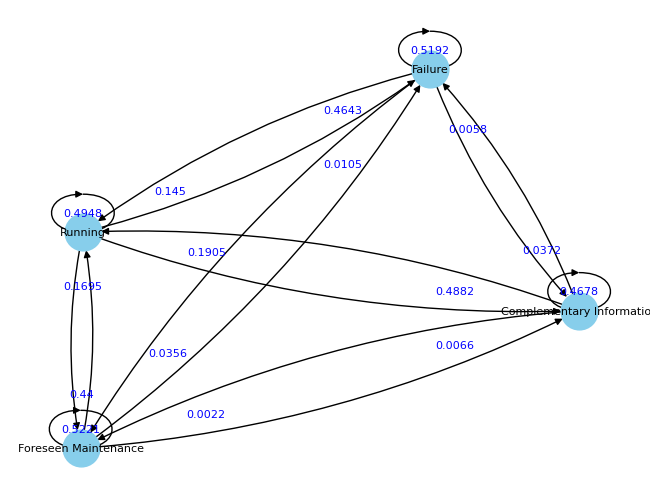

In [239]:
markov_graph(transitions_probs)

##### Capacity Modeling: todo number 3

In [ ]:
#Orthogonal Series Density Estimation:
#area in estimator is not 1?
def Phi(x,j):
    #Orthogonal functions family
    if j == 0:
        return 1
    else:
        return np.sqrt(2)*np.cos(np.pi*j*x)

def OrthogonalSeriesEstimator(X, Phi, J):
    """
    Calculates the estimators of the coefficients of the orthogonal series associated to the famili Phi_j
    up to J
    inputs:
    X: vector containing samples
    Phi: function in x and j
    J: cutoff integer
    returns: array a_0, ..., a_j
    todo: vectorify it
    """
    a = []
    n_samples = len(X)
    for j in range(0,J+1):
        Phi_k = np.vectorize(lambda x: Phi(x,j))
        a_vec = Phi_k(X)
        a.append(np.sum(a_vec)/ n_samples)
    
    return np.array(a)

def OrthogonalSeriesFun(x, Phi, a):
    Phix = np.vectorize(lambda j : Phi(x,j))
    J = len(a)
    return np.dot(a, Phix(np.arange(J)))

def Cutoff(X, Phi):
    #redo
    N = len(X)
    for j in range(1, N):
        Phi_j = lambda x: Phi(x,j)
        a_vec = Phi_k(X)
        a_hat = np.sum(a_vec) / N
        if 2 > j * (a_hat**2):
            return j

X = np.random.exponential(scale = 1, size=1000)
X = X / np.max(X)
a = OrthogonalSeriesEstimator(X, Phi, 3)
pdf_appr = lambda x : OrthogonalSeriesFun(x, Phi, a)

X1 = np.linspace(0,1,100)
Y1 = []
for i in range(100):
    y = pdf_appr(X1[i])
    Y1.append(y)
    
Y1 = np.array(Y1)
plt.plot(X1, Y1)
plt.hist(X, density = True)


In [ ]:
#With Orthogonal Series Decomposizion ---> meh

grouped_df = df.groupby(["ProductionType", "Type"])
#idea: calculate prob for capacity = 0, remove and the use non parametric fit.
for production_type, prod_df in grouped_df:
    #calculate per unit available capacity
    PU = prod_df["AvailableCapacity"] / prod_df["InstalledCapacity"]
    df.loc[(df["ProductionType"] == production_type[0]) & (df["Type"] == production_type[1]), "p.u."] = PU
    PU = PU[~np.isnan(PU)]
    p_0 = np.sum(PU == 0) / len(PU)
    PUplus = PU[PU != 0] #non zero capacities
    if len(PUplus) != 0:
        a = OrthogonalSeriesEstimator(PUplus, Phi, 10)
        pdf = lambda x: OrthogonalSeriesFun(x, Phi, a)
        vec_pdf = np.vectorize(pdf)
    
         # Plot histogram

        plt.xlim(0, 1)
        plt.plot(np.sort(PUplus), vec_pdf(np.sort(PUplus)))
        plt.hist(PU, bins=min(500, int(np.ceil(len(PU) ** (1. / 3))*3/2)) + 3 , edgecolor='black', alpha=0.7, density = True)

        # Customize the plot (add labels, title, etc.)
        plt.xlabel('p.u. Available Capacity')
        plt.ylabel('Frequency')
        plt.title(f'{production_type}')
        plt.show()